# The Flow-Based Spatial Interaction Model (FSIM) Framework

---

## The flow-based spatial interaction model(FSIM)

### A general form of the gravity-based spatial interaction model

Spatial interaction models, or more precisely, gravity models, have been widely used to predict travel or to measure the interaction potential between two locations in space. Its basic form can be written as follows:

$$\tag1I_(i,j) = P_i*P_j*C_{ij}$$

$$\tag2C_{ij} = e^{-\beta*d_{ij}}$$

where $P_i$ and $P_j$ are the attractiveness of places $i$ and $j$, respectively. $C_{ij}$ os a distance decay function, and it can be specified in exponential form, in which $\beta$ is a calibrated parameter and $d_{ij}$ is the distance between plcaes $i$ and $j$. This expression is a basic form of urban spatial interaction between anyentities 

### Defining the distance between flows

In [1]:
# Import Packages
import pandas as pd 
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns 
import json
import pyproj
import math
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import math
from decimal import Decimal, getcontext
import time

/Users/apple/opt/anaconda3/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/21/l9ygcw6d6w39m02vcn2t_j6r0000gn/T/ipykernel_75540/811788007.py:4: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://

#### Read data

In [2]:
# Read Data
od_matrix = pd.read_excel('./data/Origin-destination matrix by station2016.xls', sheet_name='matrix')
od_matrix_zone = pd.read_excel('./data/Origin-destination matrix by station2016.xls', sheet_name='zone')
jour_pur_entry = pd.read_excel('./data/Journey purpose entry station2016.xls', sheet_name='journey purpose')
jour_pur_exit = pd.read_excel('./data/Journey purpose by exit station2016.xls', sheet_name='journey purpose')
age_gender = pd.read_excel('./data/Age, gender, mobility category by entrystation2016.xls', sheet_name='age&sex')


# 读取.shp文件
file_path = "data/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp"
# 伦敦边界
greater_london_boundary = gpd.read_file(file_path)

# 读取JSON文件中的JSON数组
with open('./data/tfl_stations.json', 'r') as file:
    stations = json.load(file)

# 读取JSON文件中的JSON数组
with open('./data/tfl_lines.json', 'r') as file:
    lines = json.load(file)

# 去掉'Name'列中字符串最后一个字符之后的空格
od_matrix['station_origin'] = od_matrix['station_origin'].str.rstrip()

od_matrix['station_destination'] = od_matrix['station_destination'].str.rstrip()

# 去掉首行中所有列的最后一个字符之后的空格
jour_pur_entry.iloc[0] = jour_pur_entry.iloc[0].str.rstrip()

# 去掉首行中所有列的最后一个字符之后的空格
jour_pur_exit.iloc[0] = jour_pur_exit.iloc[0].str.rstrip()

# 将所有列的首行大小写置换并替换空格
jour_pur_exit.columns = [col.lower().replace(' ', '_') for col in jour_pur_exit.columns]

# 将所有列的首行大小写置换并替换空格
jour_pur_entry.columns = [col.lower().replace(' ', '_') for col in jour_pur_entry.columns]

We need transform the json file, extract some elements from the json as a new dataframe

In [3]:
# 创建一个新的dataframe
columns = ['station_name','zone','coordinates']
stations_df = pd.DataFrame(columns = columns)

# 遍历 stations.json文件，取出新的dataframe需要的元素
length = len(stations['features'])
for i in range (0,length):
    tmp_name=''
    #tmp_line=''
    tmp_zone=''
    tmp_coordinates=[]
    
    tmp_name = stations['features'][i]['properties']['name']
    tmp_zone = stations['features'][i]['properties']['zone']
    tmp_coordinates = stations['features'][i]['geometry']['coordinates']
    
    # 创建一个新的数据行
    new_row = {'station_name': tmp_name, 'zone': tmp_zone, 'coordinates': tmp_coordinates}

    # 将新数据行添加到DataFrame中
    stations_df = stations_df.append(new_row, ignore_index=True)

Then transform the CRS to the British National grid so that our distances are in metres, then we need to generate a distance matrix

In [4]:
stations_df

station_name zone                               coordinates
0             Acton Town    3   [-0.279916688851386, 51.50264359676248]
1                Archway  2/3  [-0.134745288767581, 51.565370996797775]
2           Aldgate East    1   [-0.071876588767481, 51.51514719676551]
3                  Angel    1    [-0.10612998877245, 51.53182149677656]
4                Aldgate    1   [-0.075715588769394, 51.51409639676498]
..                   ...  ...                                       ...
524        Wanstead Park    3    [0.026333811285793, 51.55169999678506]
525             Woolwich    4    [0.070810011273918, 51.49178999674734]
526       Worcester Park    4                      [-0.24496, 51.38139]
527         Canary Wharf    2   [-0.017465870885524, 51.50628412783459]
528  King's Road Chelsea    1                      [-0.16701, 51.48835]

[529 rows x 3 columns]

In [4]:
# Transform Coordinates from WGB84 to National Britsh Grid

# Define the CRS84 (latitude, longitude) and BNG (British National Grid) coordinate reference systems
crs84 = pyproj.CRS("EPSG:4326")  # EPSG code for CRS84 (WGS 84)
bng = pyproj.CRS("EPSG:27700")   # EPSG code for British National Grid

# Create a coordinate transformer
transformer = pyproj.Transformer.from_crs(crs84, bng, always_xy=True)

coord_x = []
coord_y = []

# Transform the coordinates and update the JSON
for i in range (0,len(stations_df)):
    lon, lat = stations_df['coordinates'][i][0], stations_df['coordinates'][i][1]
    x, y = transformer.transform(lon, lat)
    coord_x.append(x)
    coord_y.append(y)
    
    
stations_df["coordinates_x"] = coord_x
stations_df["coordinates_y"] = coord_y

#### Merge the "stations_df" and "od_matrix", assign the "od_matrix" new coordinates columns

In [5]:
# create new columns
# Transformed coord
od_matrix['orig_x'] = None
od_matrix['orig_y'] = None
od_matrix['dest_x'] = None
od_matrix['dest_y'] = None
# Latitude and Longitude
od_matrix['orig_coord_lat'] = None
od_matrix['orig_coord_lon'] = None
od_matrix['dest_coord_lat'] = None
od_matrix['dest_coord_lon'] = None

for i in range(0,len(od_matrix)):
    for j in range(0,len(stations_df)):
        if(od_matrix['station_origin'][i] == stations_df['station_name'][j]):
            # 加入origin的坐标
            od_matrix.loc[i,'orig_x'] = stations_df['coordinates_x'][j]
            od_matrix.loc[i,'orig_y'] = stations_df['coordinates_y'][j]
            # 加入origin的经纬度
            od_matrix.loc[i,'orig_coord_lat'] = stations_df['coordinates'][j][0]
            od_matrix.loc[i,'orig_coord_lon'] = stations_df['coordinates'][j][1]
            
        if(od_matrix['station_destination'][i] == stations_df['station_name'][j]):
            # 加入destination的坐标
            od_matrix.loc[i,'dest_x'] = stations_df['coordinates_x'][j]
            od_matrix.loc[i,'dest_y'] = stations_df['coordinates_y'][j]
            # 加入origin的经纬度
            od_matrix.loc[i,'dest_coord_lat'] = stations_df['coordinates'][j][0]
            od_matrix.loc[i,'dest_coord_lon'] = stations_df['coordinates'][j][1]

#### Delete the NaN values

In [7]:
od_matrix.columns

Index(['From', 'station_origin', 'To', 'station_destination', 'early_flows',
       'ampeak_flows', 'midday_flows', 'pmpeak_flows', 'evening_flows',
       'late_flows', 'total_flows', 'orig_x', 'orig_y', 'dest_x', 'dest_y',
       'orig_coord_lat', 'orig_coord_lon', 'dest_coord_lat', 'dest_coord_lon'],
      dtype='object')

In [6]:
# 检查每一列中NaN值的数量
nan_count_by_column = od_matrix.isna().sum()

# 检查每一行中NaN值的数量
nan_count_by_row = od_matrix.isna().sum(axis=1)

print("NaN值的数量按列计算：")
print(nan_count_by_column)

print("\nNaN值的数量按行计算：")
print(nan_count_by_row)

NaN值的数量按列计算：
From                      0
station_origin            0
To                        0
station_destination       0
early_flows               0
ampeak_flows              0
midday_flows              0
pmpeak_flows              0
evening_flows             0
late_flows                0
total_flows               0
orig_x                 1073
orig_y                 1073
dest_x                 1028
dest_y                 1028
orig_coord_lat         1073
orig_coord_lon         1073
dest_coord_lat         1028
dest_coord_lon         1028
dtype: int64

NaN值的数量按行计算：
0        0
1        0
2        0
3        0
4        0
        ..
34517    0
34518    0
34519    0
34520    0
34521    0
Length: 34522, dtype: int64


Check the cleaned matrix

In [7]:
# 去除掉Nan值
od_matrix_cleaned = od_matrix.dropna()

# 检查每一列中NaN值的数量
nan_count_by_column = od_matrix_cleaned.isna().sum()

# 检查每一行中NaN值的数量
nan_count_by_row = od_matrix_cleaned.isna().sum(axis=1)

print("NaN值的数量按列计算：")
print(nan_count_by_column)

print("\nNaN值的数量按行计算：")
print(nan_count_by_row)

NaN值的数量按列计算：
From                   0
station_origin         0
To                     0
station_destination    0
early_flows            0
ampeak_flows           0
midday_flows           0
pmpeak_flows           0
evening_flows          0
late_flows             0
total_flows            0
orig_x                 0
orig_y                 0
dest_x                 0
dest_y                 0
orig_coord_lat         0
orig_coord_lon         0
dest_coord_lat         0
dest_coord_lon         0
dtype: int64

NaN值的数量按行计算：
0        0
1        0
2        0
3        0
4        0
        ..
34517    0
34518    0
34519    0
34520    0
34521    0
Length: 32440, dtype: int64


#### Plot the bounries map

In [8]:
# Read London Data
file = "./data/LAD_Dec_2015_Generalised_Clipped_Boundaries_GB.geojson"
EW = gpd.read_file(file)

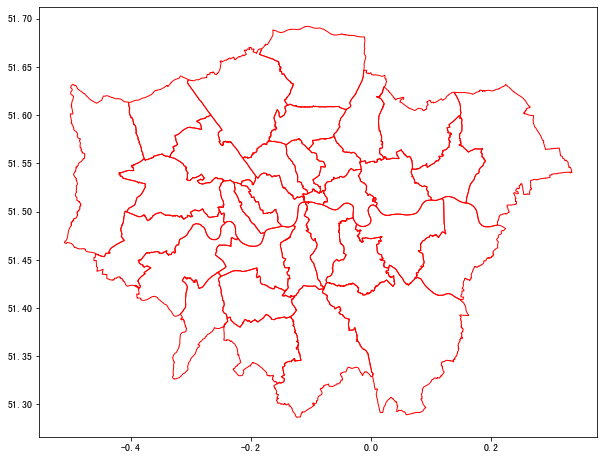

In [9]:
London = EW[EW.lad15cd.str.contains("E09")]
London.plot(figsize = (10,15), facecolor = "None", edgecolor = "r")
plt.show()

In [10]:
# 将'A'列从float型转换为int型
od_matrix_cleaned['orig_x'].apply(lambda x: float(x))
od_matrix_cleaned['dest_x'].apply(lambda x: float(x))
od_matrix_cleaned['orig_y'].apply(lambda x: float(x))
od_matrix_cleaned['dest_y'].apply(lambda x: float(x))

0        183776.369709
1        198187.137516
2        183134.536266
3        186814.395591
4        186022.599666
             ...      
34517    179921.098738
34518    177996.875504
34519    191627.185882
34520    179658.047643
34521    180732.601286
Name: dest_y, Length: 32440, dtype: float64

/Users/apple/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


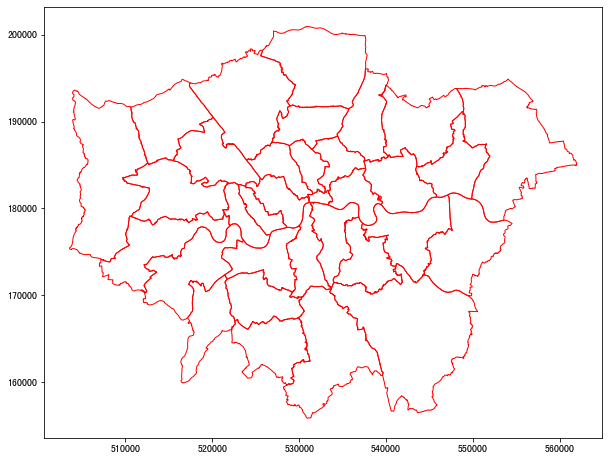

In [11]:
#transform london to BNG
London.to_crs("EPSG:27700", inplace = True)
#We can check that this has occured by plotting the results
London.plot(figsize = (10,15), facecolor = "None", edgecolor = "r")
plt.show()

#### Select the data within the boundary

In [12]:
# 创建British National Grid坐标系的投影对象
proj_bng = pyproj.Proj(init='epsg:27700')  # EPSG:27700是British National Grid坐标系的代码

# 定义一个函数，将经纬度转换为British National Grid坐标系
def lat_lon_to_bng(lat, lon):
    x, y = proj_bng(lat, lon)
    return Point(x, y)

# 假设你的DataFrame为df，包含了经纬度数据
# 将经纬度转换为British National Grid坐标系，并创建对应的geometry列
od_matrix_cleaned['geometry1'] = od_matrix_cleaned.apply(lambda row: lat_lon_to_bng(row['orig_coord_lat'], row['orig_coord_lon']), axis=1)
od_matrix_cleaned['geometry2'] = od_matrix_cleaned.apply(lambda row: lat_lon_to_bng(row['dest_coord_lat'], row['dest_coord_lon']), axis=1)

# 创建GeoDataFrame，并设置其坐标系为British National Grid
gdf1 = gpd.GeoDataFrame(od_matrix_cleaned, crs='EPSG:27700', geometry='geometry1')
gdf2 = gpd.GeoDataFrame(od_matrix_cleaned, crs='EPSG:27700', geometry='geometry2')

# 进行空间连接，筛选出在Greater London Authority边界内的数据行
data_in_greater_london1 = gpd.sjoin(gdf1, greater_london_boundary, how='inner', op='within')
data_in_greater_london2 = gpd.sjoin(gdf2, greater_london_boundary, how='inner', op='within')

/Users/apple/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/21/l9ygcw6d6w39m02vcn2t_j6r0000gn/T/ipykernel_75540/396768181.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  od_matrix_cleaned['geometry1'] = od_matrix_cleaned.apply(lambda row: lat_lon_to_bng(row['orig_coord_lat'], row['orig_coord_lon']), axis=1)
/var/folders/21/l9ygcw6d6w39m02vcn2t_j6r0000gn/T/ipykernel_75540/396768181.py:12: Setti

In [13]:
new_df1= data_in_greater_london1[['From', 'station_origin', 'To', 'station_destination', 'early_flows',
       'ampeak_flows', 'midday_flows', 'pmpeak_flows', 'evening_flows',
       'late_flows', 'total_flows', 'orig_x', 'orig_y', 'dest_x', 'dest_y',
       'orig_coord_lat', 'orig_coord_lon', 'dest_coord_lat', 'dest_coord_lon']]

new_df2= data_in_greater_london2[['From', 'station_origin', 'To', 'station_destination', 'early_flows',
       'ampeak_flows', 'midday_flows', 'pmpeak_flows', 'evening_flows',
       'late_flows', 'total_flows', 'orig_x', 'orig_y', 'dest_x', 'dest_y',
       'orig_coord_lat', 'orig_coord_lon', 'dest_coord_lat', 'dest_coord_lon']]


od_matrix_cleaned = pd.merge(new_df1, new_df2, on=['From', 'station_origin', 'To', 'station_destination', 'early_flows',
       'ampeak_flows', 'midday_flows', 'pmpeak_flows', 'evening_flows',
       'late_flows', 'total_flows', 'orig_x', 'orig_y', 'dest_x', 'dest_y',
       'orig_coord_lat', 'orig_coord_lon', 'dest_coord_lat', 'dest_coord_lon'], how='inner')

<font color=red>**Calculate the number of 'home','Work','Shop','Education','Tourist','Hotel' for each station** (这部分暂时无用)</font>

**Home**: Entry 数据集中的 Entry Purpose -> Home

**Work**: Destination 数据集中的 Exit Purpose -> Work

**Shop**: Destination 数据集中的 Exit Purpose -> Shop

**Education**: Destination 数据集中的 Exit Purpose -> Education

**Tourist**: Destination 数据集中的 Exit Purpose -> Tourist

In [16]:
# # 处理DataFrame中的"Name"列，删除字符串前后的空格
# jour_pur_entry['time_period'] = jour_pur_entry['time_period'].str.strip().str.lower()
# jour_pur_entry['station_name'] = jour_pur_entry['station_name'].str.strip()

# # 按照total day的条件筛选出部分数据
# jour_entry = jour_pur_entry[jour_pur_entry['time_period'] == 'total day']


# # 处理DataFrame中的"Name"列，删除字符串前后的空格
# jour_pur_exit['period'] = jour_pur_exit['period'].str.strip().str.lower()
# jour_pur_exit['station_name'] = jour_pur_exit['station_name'].str.strip()

# # 按照total day的条件筛选出部分数据
# jour_exit = jour_pur_exit[jour_pur_exit['period'] == 'total day']

In [17]:
# # 只筛选出一些column
# jour_entry = jour_entry[['station_name','home(orig)']]

# jour_exit= jour_exit[['station_name','work(dest)','shop(dest)','education(dest)', 'tourist(dest)', 'hotel(dest)']]

# # Rename column names
# new_column_names_entry = ['station_name', 'home']
# new_column_names_exit = ['station_name','work','shop','education', 'tourist', 'hotel']

# jour_entry.columns = new_column_names_entry
# jour_exit.columns = new_column_names_exit

In [18]:
# # 重新整理索引从0开始
# jour_entry.reset_index(drop=True, inplace=True)

# # 重新整理索引从0开始
# jour_exit.reset_index(drop=True, inplace=True)

# # 重新整理索引从0开始
# od_matrix_cleaned.reset_index(drop=True, inplace=True)

In [19]:
# jour_entry['station_name'][4]

In [20]:
# # 将每条flow中，地铁站起点和终点的home的数量分别赋值给他们
# for i in range(0,len(od_matrix_cleaned)):
#     for j in range(0,len(jour_entry)):
#         if(od_matrix_cleaned['station_origin'][i] == jour_entry['station_name'][j]):
#             #od_matrix_cleaned['home_orig'] = jour_entry['home']
#             od_matrix_cleaned.loc[i,'home_orig'] = jour_entry['home'][j]
#         if(od_matrix_cleaned['station_destination'][i] == jour_entry['station_name'][j]):          
#             od_matrix_cleaned.loc[i,'home_dest'] = jour_entry['home'][j]
            
# # 将每条flow中，地铁站起点和终点的home的数量分别赋值给他们
# for i in range(0,len(od_matrix_cleaned)):
#     for j in range(0,len(jour_exit)):
#         if(od_matrix_cleaned['station_origin'][i] == jour_exit['station_name'][j]):
#             od_matrix_cleaned.loc[i,'work_orig'] = jour_exit['work'][j]
#             od_matrix_cleaned.loc[i,'shop_orig'] = jour_exit['shop'][j]
#             od_matrix_cleaned.loc[i,'education_orig'] = jour_exit['education'][j]
#             od_matrix_cleaned.loc[i,'tourist_orig'] = jour_exit['tourist'][j]
#             od_matrix_cleaned.loc[i,'hotel_orig'] = jour_exit['hotel'][j]
            
#         if(od_matrix_cleaned['station_destination'][i] == jour_exit['station_name'][j]):
#             od_matrix_cleaned.loc[i,'work_dest'] = jour_exit['work'][j]
#             od_matrix_cleaned.loc[i,'shop_dest'] = jour_exit['shop'][j]
#             od_matrix_cleaned.loc[i,'education_dest'] = jour_exit['education'][j]
#             od_matrix_cleaned.loc[i,'tourist_dest'] = jour_exit['tourist'][j]
#             od_matrix_cleaned.loc[i,'hotel_dest'] = jour_exit['hotel'][j]

In [21]:
# od_matrix_cleaned.isna().sum()

In [22]:
# # 去除掉Nan值
# od_matrix_cleaned = od_matrix_cleaned.dropna()
# od_matrix_cleaned.reset_index(drop=True, inplace=True)

In [23]:
# od_matrix_cleaned.isna().sum()

### Quantifying the flow-based spatial interaction potential

Employing this distance metric in a form similar to that shown in Eq.(1), we can have an approach of quantifying the interaction between two flows, $u$ and $v$, shown as two vectors in a planar space.

Thus, the following equation can be written

$$\tag5I_{(ij,i'j')} = P_{ij}*P_{i'j'}*C_{(ij,i'j')} = P_{ij}*P_{i'j'}*e^{-\beta*d_{(ij,i'j')}}$$

Then, this interaction potentialo can be aggregated by any flow in question. In doing so, we will have the following:

$$\tag6 I_{ij} = \Sigma_{(i'j')}P_{ij}P_{i'j'}e^{-\beta*d_{(ij,i'j')}}$$

This expression is a sum of the flow-based spatial interactions starting from a place to another. From a geographical perspective, **the flow-based spatial interaction potential (FSIP) between any two places $(I_{ij})$= $i$ and $j$, for instance-is measured as the cumulative potential of the spatial interaction between the flow occurring between $i$ and $j$ and its neighbouring flows happened between any two places $i'$ and $j'$**

$$\tag7 I_i = \Sigma_{j} I_{(ij)} = \Sigma_{j}\Sigma_{(i'j')} P_{ij}*P_{i'j'}e^{-\beta*d_{(ij,i'j')}}$$

In [14]:
stop

NameError: name 'stop' is not defined

---

In [15]:
beta = 0.91
e_val = math.e 

In [16]:
####### calculate the distance
### (x1,y1) point to (x3,y3)
### (x2,x2) point to (x4,y4)

### The distance calculation equation:
# d(13,24) = sqrt((x1-x3)**2 + (x2-x4)**2 + (y1-y3)**2 + (y2-y4)**2)
# 设置 numpy 打印选项，保留两位小数，并以科学计数法显示
np.set_printoptions(precision=6, suppress=True)

# fsip' represents for "Flow-Based Spatial Interaction Potential"
def distance_decay_function(x1,y1,x2,y2,x3,y3,x4,y4):
    distance = math.sqrt((x1-x3)**2 + (x2-x4)**2 + (y1-y3)**2 + (y2-y4)**2)
    fsip = distance**-beta
    return fsip

The amount of people traveling between places is empolyed as the basic attractiveness of each flow - 'total_flows'(column)

In [17]:
# 将'A'列从float型转换为int型
od_matrix_cleaned['orig_x'] = od_matrix_cleaned['orig_x'].astype(int)
od_matrix_cleaned['orig_y'] = od_matrix_cleaned['orig_y'].astype(int)
od_matrix_cleaned['dest_x'] = od_matrix_cleaned['dest_x'].astype(int)
od_matrix_cleaned['dest_y'] = od_matrix_cleaned['dest_y'].astype(int)

In [18]:
# 新声明一个列名为 'fsip'，并将其所有值设置为NaN
od_matrix_cleaned['fsip'] = None

#### **Calculate the FSIP (Based on the totoal_flows)**

In [19]:
od_matrix_cleaned.shape

(30234, 20)

In [20]:
# 代码块开始之前记录开始时间
start_time = time.time()

for i in range(0,len(od_matrix_cleaned)):
    # 找寻所有邻居，邻居定义为首尾相连的flow
    tmp_station = od_matrix_cleaned['station_origin'][i]
    tmp_row = od_matrix_cleaned.iloc[[i]]
    #tmp_df = pd.DataFrame()
    tmp_fsip = 0
    tmp_distance=0
    tmp_fsip_ampeak=0
    
    #tmp_df = pd.DataFrame(columns=['station_name', 'total_flows', 'orig_x','orig_y','dest_x','dest_y'])
    
    tmp_df1 = od_matrix_cleaned[od_matrix_cleaned['station_origin'] == tmp_station]
    tmp_df2 = od_matrix_cleaned[od_matrix_cleaned['station_destination'] == tmp_station]
    
    tmp_df = pd.concat([tmp_df1,tmp_df2])
    tmp_df.reset_index(drop=True, inplace=True)
    
    # 将新的数据行加入到DataFrame的第一行
    tmp_row_df = pd.DataFrame(tmp_row)
    tmp_df = pd.concat([tmp_row_df, tmp_df], ignore_index=True)
    
    # 2.按照公式计算出$I_{(ij)}$ (每个flow和它的所有邻居一起计算)
    for j in range(1,len(tmp_df)):
        tmp_distance = distance_decay_function(tmp_df['orig_x'][0],tmp_df['orig_y'][0],
                                tmp_df['orig_x'][0],tmp_df['orig_y'][0],
                                tmp_df['dest_x'][0],tmp_df['dest_y'][0],
                                tmp_df['dest_x'][j],tmp_df['dest_y'][j])
        tmp_fsip += tmp_df['total_flows'][0] * tmp_df['total_flows'][j] * tmp_distance
        tmp_fsip_ampeak += tmp_df['ampeak_flows'][0] * tmp_df['ampeak_flows'][j] * tmp_distance

    od_matrix_cleaned.at[i, 'fsip'] = tmp_fsip
    od_matrix_cleaned.at[i, 'fsip_ampeak'] = tmp_fsip_ampeak

# 代码块结束后记录结束时间
end_time = time.time()

In [21]:
# 计算运行时间差
execution_time = end_time - start_time

print(f"代码块的运行时间：{execution_time} 秒")

代码块的运行时间：684.7379767894745 秒


#### **The FSIP(根据ampeak_flows)计算的** Calculate the FSIP (Based on the ampeak_flows)

In [31]:
# todo

#### Calculate the FSIP (Based on the pmpeak_flows)

In [32]:
# todo

---- 

#### Calculate the real distance between each pair of stations

接下来我将先计算两两地铁站之间的实际距离；
根据实际距离与不同group出行的平均距离数据，可以估计每条flow中属于每个不同group的flow数

In [24]:
from math import radians, sin, cos, sqrt, atan2

def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1_rad = radians(lat1)
    lon1_rad = radians(lon1)
    lat2_rad = radians(lat2)
    lon2_rad = radians(lon2)

    # Earth radius in meters
    R = 6371000.0

    # Haversine formula
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = sin(dlat/2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c

    return distance


# 使用apply函数逐行应用haversine_distance函数，并将结果赋值给新的一列'station_dis'
od_matrix_cleaned['station_dis'] = od_matrix_cleaned.apply(lambda row: haversine_distance(row['orig_coord_lat'], row['orig_coord_lon'], row['dest_coord_lat'], row['dest_coord_lon'])/1000, axis=1)

- full time student / routine occupations: 10.9 + 10.6 / 2 = 10.75 (10.6, 10.9)

- large employers and higher managerial professionals: 16.5 + 23.5 + 19.7 + 15.5 /4 = 18.8 (15.5, 23.5); median-> 19.5

- small employers and own-account workers: 14.7 + 20.4 + 20.5 + 8.6 + 3.9 + 13.4 + 16.1 / 7 = 13.94 (3.9, 20.5); median -> 12.2

#### Calculate the 'ampeaks_flows' distribution of each flow

In [25]:
ampeak_data = [
    ['AM peak', 'towork', 1039130, 155573, 383765, 355967, 106727, 37098],
    ['AM peak', 'toeducation', 363681, 60005, 139270, 121870, 33580, 8954],
    ['AM peak', 'toother', 905973, 201876, 387185, 229998, 61835, 25083]
]

columns = ['Time period', 'Origin Journey Purpose : Destination Journey Purpose', 'Total', '< 3 kms', '3 - 8 kms', '8 - 16 kms', '16 - 24 kms', 'over 24 kms']

ampeak_dis = pd.DataFrame(ampeak_data, columns=columns)
ampeak_dis

Time period Origin Journey Purpose : Destination Journey Purpose    Total  \
0     AM peak                                             towork    1039130   
1     AM peak                                        toeducation     363681   
2     AM peak                                            toother     905973   

   < 3 kms  3 - 8 kms  8 - 16 kms  16 - 24 kms  over 24 kms  
0   155573     383765      355967       106727        37098  
1    60005     139270      121870        33580         8954  
2   201876     387185      229998        61835        25083

In [97]:
len(od_matrix_cleaned['station_origin'].unique())

243

计算每个group的占比

In [26]:
# Calculate the <3kms column
total_3km = ampeak_dis['< 3 kms'].sum()
ampeak_dis['<3_per'] = ampeak_dis['< 3 kms']/total_3km

# Calculate the 3-8km column
total_38km = ampeak_dis['3 - 8 kms'].sum()
ampeak_dis['38km_per'] = ampeak_dis['3 - 8 kms']/total_38km

# Calculate the 8-16km column
total_816km = ampeak_dis['8 - 16 kms'].sum()
ampeak_dis['816km_per'] = ampeak_dis['8 - 16 kms']/total_816km

# Calculate the 16-24km column
total_1624km = ampeak_dis['16 - 24 kms'].sum()
ampeak_dis['1624km_per'] = ampeak_dis['16 - 24 kms']/total_1624km

# Calculate the over24km column
total_over24km = ampeak_dis['over 24 kms'].sum()
ampeak_dis['over24km_per'] = ampeak_dis['over 24 kms']/total_over24km
ampeak_dis

Time period Origin Journey Purpose : Destination Journey Purpose    Total  \
0     AM peak                                             towork    1039130   
1     AM peak                                        toeducation     363681   
2     AM peak                                            toother     905973   

   < 3 kms  3 - 8 kms  8 - 16 kms  16 - 24 kms  over 24 kms    <3_per  \
0   155573     383765      355967       106727        37098  0.372671   
1    60005     139270      121870        33580         8954  0.143740   
2   201876     387185      229998        61835        25083  0.483589   

   38km_per  816km_per  1624km_per  over24km_per  
0  0.421618   0.502895    0.527980      0.521515  
1  0.153007   0.172173    0.166121      0.125873  
2  0.425375   0.324932    0.305899      0.352611

---

判断逻辑：

1. 先判断两个station之间的距离属于哪个区间；


2. 计算在所属区间中，属于每个groupd的占比


3. 换算出ampeak_flows中属于 fromwork, fromeducation, from other的flows分别为多少

计算每条流里属于各个group的流数量

In [27]:
od_matrix_cleaned['ampeak_2work_flows'] = 0
od_matrix_cleaned['ampeak_2edu_flows'] = 0
od_matrix_cleaned['ampeak_2other_flows'] = 0

for i in range(0,len(od_matrix_cleaned)):
    if(od_matrix_cleaned['station_dis'][i] < 3):
        od_matrix_cleaned['ampeak_2work_flows'][i] = ampeak_dis['<3_per'][0]*od_matrix_cleaned['ampeak_flows'][i]
        od_matrix_cleaned['ampeak_2edu_flows'][i] = ampeak_dis['<3_per'][1]*od_matrix_cleaned['ampeak_flows'][i]
        od_matrix_cleaned['ampeak_2other_flows'][i] = ampeak_dis['<3_per'][2]*od_matrix_cleaned['ampeak_flows'][i]
        
    elif(3<= od_matrix_cleaned['station_dis'][i] <8):
        od_matrix_cleaned['ampeak_2work_flows'][i] = ampeak_dis['38km_per'][0]*od_matrix_cleaned['ampeak_flows'][i]
        od_matrix_cleaned['ampeak_2edu_flows'][i] = ampeak_dis['38km_per'][1]*od_matrix_cleaned['ampeak_flows'][i]
        od_matrix_cleaned['ampeak_2other_flows'][i] = ampeak_dis['38km_per'][2]*od_matrix_cleaned['ampeak_flows'][i]
        
    elif(8<= od_matrix_cleaned['station_dis'][i] <16):
        od_matrix_cleaned['ampeak_2work_flows'][i] = ampeak_dis['816km_per'][0]*od_matrix_cleaned['ampeak_flows'][i]
        od_matrix_cleaned['ampeak_2edu_flows'][i] = ampeak_dis['816km_per'][1]*od_matrix_cleaned['ampeak_flows'][i]
        od_matrix_cleaned['ampeak_2other_flows'][i] = ampeak_dis['816km_per'][2]*od_matrix_cleaned['ampeak_flows'][i]
        
    elif(16<= od_matrix_cleaned['station_dis'][i] <24):
        od_matrix_cleaned['ampeak_2work_flows'][i] = ampeak_dis['1624km_per'][0]*od_matrix_cleaned['ampeak_flows'][i]
        od_matrix_cleaned['ampeak_2edu_flows'][i] = ampeak_dis['1624km_per'][1]*od_matrix_cleaned['ampeak_flows'][i]
        od_matrix_cleaned['ampeak_2other_flows'][i] = ampeak_dis['1624km_per'][2]*od_matrix_cleaned['ampeak_flows'][i]
        
    elif(24<= od_matrix_cleaned['station_dis'][i]):
        od_matrix_cleaned['ampeak_2work_flows'][i] = ampeak_dis['over24km_per'][0]*od_matrix_cleaned['ampeak_flows'][i]
        od_matrix_cleaned['ampeak_2edu_flows'][i] = ampeak_dis['over24km_per'][1]*od_matrix_cleaned['ampeak_flows'][i]
        od_matrix_cleaned['ampeak_2other_flows'][i] = ampeak_dis['over24km_per'][2]*od_matrix_cleaned['ampeak_flows'][i]
    
    

/var/folders/21/l9ygcw6d6w39m02vcn2t_j6r0000gn/T/ipykernel_75540/3775047481.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  od_matrix_cleaned['ampeak_2work_flows'][i] = ampeak_dis['38km_per'][0]*od_matrix_cleaned['ampeak_flows'][i]
/var/folders/21/l9ygcw6d6w39m02vcn2t_j6r0000gn/T/ipykernel_75540/3775047481.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  od_matrix_cleaned['ampeak_2edu_flows'][i] = ampeak_dis['38km_per'][1]*od_matrix_cleaned['ampeak_flows'][i]
/var/folders/21/l9ygcw6d6w39m02vcn2t_j6r0000gn/T/ipykernel_75540/3775047481.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [ ]:
od_matrix_cleaned.iloc[850]

In [ ]:
# def cal_ampeak_flows_distribution(value,flows):
#     print(flows)
#     for i in range(0,len(flows)):
#         #print(i)
#         if value < 3:
#             return int(flows[i]*ampeak_dis['<3_per'][0]),int(flows[i]*ampeak_dis['<3_per'][1]),int(flows[i]*ampeak_dis['<3_per'][2])
#         elif 3<= value < 8:
#             return int(flows[i]*ampeak_dis['38km_per'][0]),int(flows[i]*ampeak_dis['38km_per'][1]),int(flows[i]*ampeak_dis['38km_per'][2])
#         elif 8<= value < 16:
#             return int(flows[i]*ampeak_dis['816km_per'][0]),int(flows[i]*ampeak_dis['816km_per'][1]),int(flows[i]*ampeak_dis['816km_per'][2])
#         elif 16<= value < 24:
#             return int(flows[i]*ampeak_dis['1624km_per'][0]),int(flows[i]*ampeak_dis['1624km_per'][1]),int(flows[i]*ampeak_dis['1624km_per'][2])
#         elif 24 <= value:
#             return int(flows[i]*ampeak_dis['over24km_per'][0]),int(flows[i]*ampeak_dis['over24km_per'][1]),int(flows[i]*ampeak_dis['over24km_per'][2])

# ampeak_flows = od_matrix_cleaned['ampeak_flows']
# od_matrix_cleaned[['ampeak_2work_flows','ampeak_2edu_flows','ampeak_2other_flows']] = 


# od_matrix_cleaned['station_dis'].apply(lambda x: pd.Series(cal_ampeak_flows_distribution(x,ampeak_flows)))

#### Calculate the 'pmpeak_flows' distribution of each flow

In [28]:
pmpeak_data = {
    'Time period': ['PM peak', 'PM peak', 'PM peak'],
    'Origin Journey Purpose : Destination Journey Purpose': ['fromwork', 'fromeducation', 'fromother'],
    'Average': [7.5, 7.45, 7.42],
    'Total': [752147, 79337, 138671],
    '< 3 kms': [271465, 11338, 26032],
    '3 - 8 kms': [241196, 31849, 59859],
    '8 - 16 kms': [87151, 26156, 36634],
    '16 - 24 kms': [106727, 7425, 9909],
    'over 24 kms': [27946, 2568, 6235]
}

pmpeak_dis = pd.DataFrame(pmpeak_data)

In [44]:
# Calculate the <3kms column
total_3km = pmpeak_dis['< 3 kms'].sum()
pmpeak_dis['<3_per'] = pmpeak_dis['< 3 kms']/total_3km

# Calculate the 3-8km column
total_38km = pmpeak_dis['3 - 8 kms'].sum()
pmpeak_dis['38km_per'] = pmpeak_dis['3 - 8 kms']/total_38km

# Calculate the 8-16km column
total_816km = pmpeak_dis['8 - 16 kms'].sum()
pmpeak_dis['816km_per'] = pmpeak_dis['8 - 16 kms']/total_816km

# Calculate the 16-24km column
total_1624km = pmpeak_dis['16 - 24 kms'].sum()
pmpeak_dis['1624km_per'] = pmpeak_dis['16 - 24 kms']/total_1624km

# Calculate the over24km column
total_over24km = pmpeak_dis['over 24 kms'].sum()
pmpeak_dis['over24km_per'] = pmpeak_dis['over 24 kms']/total_over24km
pmpeak_dis

Time period Origin Journey Purpose : Destination Journey Purpose  Average  \
0     PM peak                                           fromwork       7.50   
1     PM peak                                      fromeducation       7.45   
2     PM peak                                          fromother       7.42   

    Total  < 3 kms  3 - 8 kms  8 - 16 kms  16 - 24 kms  over 24 kms    <3_per  \
0  752147   271465     241196       87151       106727        27946  0.878997   
1   79337    11338      31849       26156         7425         2568  0.036712   
2  138671    26032      59859       36634         9909         6235  0.084291   

   38km_per  816km_per  1624km_per  over24km_per  
0  0.724521   0.581235    0.860278      0.760456  
1  0.095670   0.174442    0.059850      0.069879  
2  0.179809   0.244323    0.079872      0.169664

---

#### Calculate the inflow and outflow for each individual station (Based on the total_flows)

In [29]:
columns = ['station_name','inflow','outflow']
inout_df = pd.DataFrame(columns = columns)
inout_df

Empty DataFrame
Columns: [station_name, inflow, outflow]
Index: []

Calculate the inflow and outflow for each individual station

In [39]:
stations_list = od_matrix_cleaned['station_origin'].unique()
tmp_inflow, tmp_outflow = 0,0


for i in range(0,len(stations_list)):
    #print(od_matrix_cleaned[od_matrix_cleaned['station_origin'] == stations_list[i]]['fsip'])
    tmp_outflow_set = set(od_matrix_cleaned[od_matrix_cleaned['station_origin'] == stations_list[i]]['fsip_ampeak'])
    tmp_outflow = sum(tmp_outflow_set)

    tmp_inflow_set = set(od_matrix_cleaned[od_matrix_cleaned['station_destination'] == stations_list[i]]['fsip_ampeak'])
    tmp_inflow = sum(tmp_inflow_set)
    
    
    new_row = {'station_name':stations_list[i], 'inflow':tmp_inflow, 'outflow':tmp_outflow}
    inout_df = inout_df.append(new_row, ignore_index=True)

#### Inflow and Outflow Visualization

In [40]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
#                 print(p)
                _x = p.get_x() + p.get_width() + float(space)
                _y = (p.get_y()-0.25) + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [47]:
# Inflow top30 stations
inout_df.sort_values(by=["inflow"],ascending= False, inplace = True)
inflow_head30 = inout_df.head(30)

# Outflow top30 stations
inout_df.sort_values(by=["outflow"],ascending= False, inplace = True)
outflow_head30 = inout_df.head(30)

In [48]:
inflow_head30.reset_index(drop=True, inplace=True) #backhere
# 获取列的前18个值并保存为一个列表
values_list = inflow_head30['station_name'].tolist()[:50]

In [49]:
od_matrix_cleaned[od_matrix_cleaned['station_origin'] == 'Brimsdown']

Empty DataFrame
Columns: [From, station_origin, To, station_destination, early_flows, ampeak_flows, midday_flows, pmpeak_flows, evening_flows, late_flows, total_flows, orig_x, orig_y, dest_x, dest_y, orig_coord_lat, orig_coord_lon, dest_coord_lat, dest_coord_lon, fsip, fsip_ampeak, station_dis, ampeak_2work_flows, ampeak_2edu_flows, ampeak_2other_flows]
Index: []

[0 rows x 25 columns]

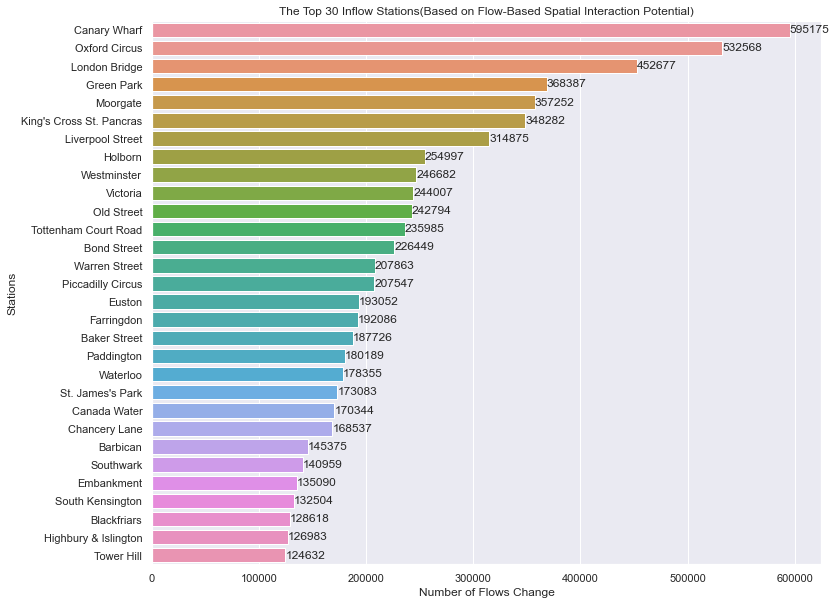

In [50]:
jp_chart = sns.barplot(y=list(inflow_head30['station_name']), x=list(inflow_head30['inflow']))

#jp_chart.set_xticklabels(list(diff_sa['station_destination'])[1:])

# for row in jp_vc10.values:
#     jp_chart.text(rorow.tip+2,round(row.tip,1),color="black",ha="center")
show_values_on_bars(jp_chart, "h", 5.0)
plt.ylabel('Stations')
plt.xlabel('Number of Flows Change')
plt.title('The Top 30 Inflow Stations(Based on Flow-Based Spatial Interaction Potential)')
sns.set(rc={'figure.figsize':(12,6)})
#plt.savefig('./essay/pic/sce_b1.png')
plt.show()

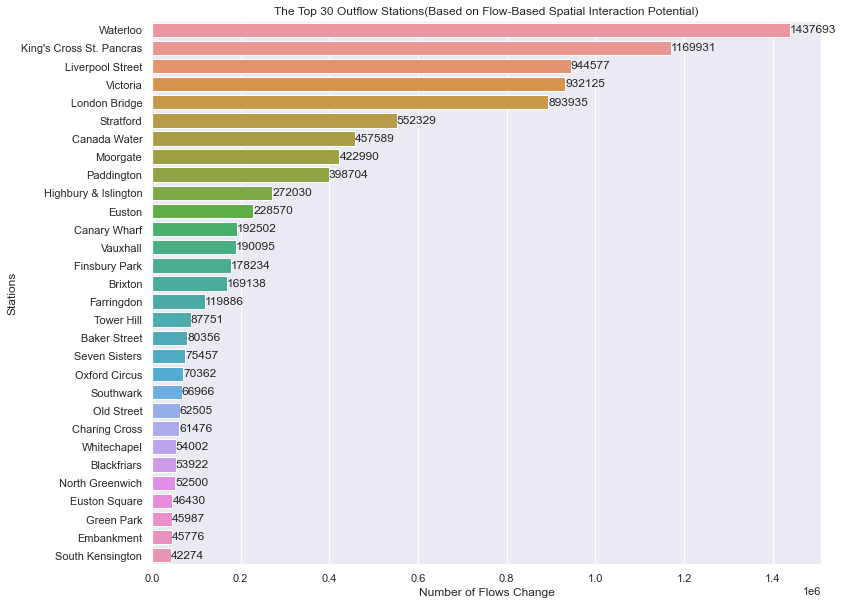

In [52]:
jp_chart = sns.barplot(y=list(outflow_head30['station_name']), x=list(outflow_head30['outflow']))

#jp_chart.set_xticklabels(list(diff_sa['station_destination'])[1:])

# for row in jp_vc10.values:
#     jp_chart.text(rorow.tip+2,round(row.tip,1),color="black",ha="center")
show_values_on_bars(jp_chart, "h", 5.0)
plt.ylabel('Stations')
plt.xlabel('Number of Flows Change')
plt.title('The Top 30 Outflow Stations(Based on Flow-Based Spatial Interaction Potential)')
sns.set(rc={'figure.figsize':(12,9)})
#plt.savefig('./essay/pic/sce_b1.png')
plt.show()

## The flow-based spatial interaction model between groups

### Flow-based spatial interaction potential between groups - absolute measures

We can compute the interaction between the flow in one group and the flow in the other group. It can be represented by the following equation:

$$\tag8 I_{(ij)}^{k->l} = \Sigma_{(i'j')}P_{(ij)}^kP_{(i'j')}^le^{-\beta d_{(ij,i'j')}}, k \neq l$$

where $P_{ij}^k$ and $P_{ij}^l$ are the attractiveness scores for flows $(i,j)$ and $(i', j')$ in groups $k$ and $l$, respectively. This metric is 'directed' from one group to another. A full representation of the spatial interactions between any flows in two different groups for a pair of places could be formally written as follows:

$$\tag9 I_{(ij)}^{k|l} = I_{(ij)}^{k->l} + I_{(ij)}^{l->k} = \Sigma_{(i'j')}P_{(ij)}^kP_{(i'j')}^le^{-\beta d_{(ij,i'j')}} + \Sigma_{(i'j')}P_{(ij)}^lP_{(i'j')}^ke^{-\beta d_{(ij,i'j')}}$$

If $k = 1$, then this interaction score turns out to be the spatial interaction for a group itself. This interaction enables quantifying the intragroup spatial interaction between flows in the same group, which is the 'concentration' of flows for a specific social group in question. It can be written as follows:

$$\tag{10} I_{(ij)}^{k} = \Sigma_{(i'j')}P_{(ij)}^kP_{(i'j')}^ke^{-\beta d_{(ij,i'j')}}$$

---

<font color=red>（这部分暂时没用）<font>

生成Male,Female DataFrame的方法：

1. 利用'Age,gender...xlsx'数据集计算每个站entry的男女的占比


2. 对于od_matrix_cleaned, 对于每条flow(以station_origin作为匹配项), 将total_flows乘以 该站男性比例 = total_male_flows


3. 对于od_matrix_cleaned, 对于每条flow, 将total_flows乘以 该女性比例 = total_female_flows

<font color=red>**Male and Female attribute generation**（这部分暂时没用）<font>

&

**Age attributes generation**

In [ ]:
# age_gender['time period'] = age_gender['time period'].str.strip().str.lower()
# # 筛选数据
# age_gender_df = age_gender[age_gender['time period'] == 'total day']

# # 对dataframe的column进行预处理
# age_gender_df.columns = [col.lower().strip() for col in age_gender_df.columns]

In [ ]:
# # 计算male和female的占比
# age_gender_df['male_per'] = age_gender_df['male'] / age_gender_df['total']
# age_gender_df['female_per'] = age_gender_df['female'] / age_gender_df['total']

# # 计算各年龄段的占比(将人群根据年龄分为三个年龄段：青少年(Under 16, 16-19, 20-24); 青壮年(25-34, 35-44, 45-59); 老年(60-64, 65-70, over 70))

# age_gender_df['total_age'] = age_gender_df['under 16'] + age_gender_df['16-19'] + age_gender_df['20-24'] + age_gender_df['25-34'] + age_gender_df['35-44'] + age_gender_df['45-59'] + age_gender_df['60-64'] + age_gender_df['65-70'] + age_gender_df['over 70']

# age_gender_df['youth_per'] = (age_gender_df['under 16'] + age_gender_df['16-19'] + age_gender_df['20-24'])/age_gender_df['total_age']
# age_gender_df['workingage_per'] = (age_gender_df['25-34'] + age_gender_df['35-44'] + age_gender_df['45-59'])/age_gender_df['total_age']
# age_gender_df['old_per'] = (age_gender_df['60-64'] + age_gender_df['over 70'])/age_gender_df['total_age']

In [ ]:
# # 筛选出部分需要column
# age_gender_df1 = age_gender_df[['station name','male_per','female_per','youth_per','workingage_per','old_per']]
# age_gender_df1['station name'] = age_gender_df1['station name'].str.strip()
# # 重新整理索引从0开始
# age_gender_df1.reset_index(drop=True, inplace=True)
# merged_df = od_matrix_cleaned.merge(age_gender_df1, left_on='station_origin', right_on='station name')

Calculate the flows of different groups

In [ ]:
# # Calculate the flows of male and female group
# merged_df['flows(male)'] = (merged_df['total_flows']*merged_df['male_per']).astype(int)
# merged_df['flows(female)'] = (merged_df['total_flows']*merged_df['female_per']).astype(int)

# # Calculate the flows of age groups
# merged_df['flows(youth)'] = (merged_df['total_flows']*merged_df['youth_per']).astype(int)
# merged_df['flows(working)'] = (merged_df['total_flows']*merged_df['workingage_per']).astype(int)
# merged_df['flows(old)'] = (merged_df['total_flows']*merged_df['old_per']).astype(int)

In [ ]:
# merged_df.columns

**The Visualization Function**

In [53]:
def odmatrix_vis(od_df, col_name):
    for i in range(0,len(od_df)):
        x1 = [od_df['orig_x'][i],  od_df['dest_x'][i]]
        y1 = [od_df['orig_y'][i],  od_df['dest_y'][i]]
        tmp_fsip = od_df[col_name][i]
        # 绘制线条并设置宽度
        quan_25 = od_df[col_name].quantile(0.2)
        quan_50 = od_df[col_name].quantile(0.5)
        quan_75 = od_df[col_name].quantile(0.8)
        quan_100 = max(od_df[col_name])


        #print(fsip_ampeak_workandedu, max(od_matrix_cleaned["place_based_fsip(other)"]))
        if(quan_75 < tmp_fsip <= quan_100):
            plt.plot(x1, y1, linewidth=tmp_fsip / max(od_df[col_name]), color='Blue',alpha=1.0)

        elif(quan_50 < tmp_fsip <= quan_75):
            plt.plot(x1, y1, linewidth=(tmp_fsip / max(od_df[col_name])), color="Green",alpha=1.0)

        elif(quan_25 < tmp_fsip <= quan_50):
            plt.plot(x1, y1, linewidth=(tmp_fsip / max(od_df[col_name])), color="Red",alpha=1.0)

        elif(tmp_fsip <= quan_25):
            plt.plot(x1, y1, linewidth=(tmp_fsip / max(od_df[col_name])), color="magenta",alpha=1.0)

In [ ]:
stop here

In [56]:
od_matrix_cleaned['fsip']

0        873.359
1        43.7629
2        5.55366
3        72.4115
4        60.2537
          ...   
30229    288.763
30230    266.694
30231     84.509
30232    343.512
30233    37.0292
Name: fsip, Length: 30234, dtype: object

---

#### Calculate the absolute attribute (To Work (Concentration))

In [ ]:
# original_od_df = od_matrix_cleaned
# random_sample_df = od_matrix_cleaned.sample(n=1000, random_state=42)  # random_state用于设置随机种子，保证结果可复现


# od_matrix_cleaned = random_sample_df

In [57]:
od_matrix_cleaned.reset_index(drop=True, inplace=True)

In [59]:
# 代码块开始之前记录开始时间
start_time = time.time()

for i in range(0,len(od_matrix_cleaned)):
    # 找寻所有邻居，邻居定义为首尾相连的flow
    tmp_station = od_matrix_cleaned['station_origin'][i]
    tmp_row = od_matrix_cleaned.iloc[[i]]
    #tmp_df = pd.DataFrame()
    tmp_fsip = 0
    tmp_distance=0
    
    #tmp_df = pd.DataFrame(columns=['station_name', 'total_flows', 'orig_x','orig_y','dest_x','dest_y'])
    
    tmp_df1 = od_matrix_cleaned[od_matrix_cleaned['station_origin'] == tmp_station]
    tmp_df2 = od_matrix_cleaned[od_matrix_cleaned['station_destination'] == tmp_station]
    
    tmp_df = pd.concat([tmp_df1,tmp_df2])
    tmp_df.reset_index(drop=True, inplace=True)
    
    # 将新的数据行加入到DataFrame的第一行
    tmp_row_df = pd.DataFrame(tmp_row)
    tmp_df = pd.concat([tmp_row_df, tmp_df], ignore_index=True)
    
    # 2.按照公式计算出$I_{(ij)}$ (每个flow和它的所有邻居一起计算)
    for j in range(1,len(tmp_df)):
        tmp_distance = distance_decay_function(tmp_df['orig_x'][0],tmp_df['orig_y'][0],
                                tmp_df['orig_x'][0],tmp_df['orig_y'][0],
                                tmp_df['dest_x'][0],tmp_df['dest_y'][0],
                                tmp_df['dest_x'][j],tmp_df['dest_y'][j])
        tmp_fsip += tmp_df['ampeak_2work_flows'][0] * tmp_df['ampeak_2work_flows'][j] * tmp_distance

    od_matrix_cleaned.at[i, 'fsip_2work'] = tmp_fsip

# 代码块开始之前记录开始时间
end_time = time.time()

In [60]:
# 计算运行时间差
execution_time = end_time - start_time
print(f"代码块的运行时间：{execution_time} 秒")

代码块的运行时间：608.8721489906311 秒


**Visualization**

In [165]:
echo = od_matrix[od_matrix['station_origin'] == 'Waterloo']

In [166]:
echo1 = od_matrix[od_matrix['station_destination'] == 'Waterloo']

In [167]:
# 使用concat函数按行合并
combined_echo = pd.concat([echo, echo1], ignore_index=True)

In [211]:
od_matrix

From station_origin   To station_destination  early_flows  \
0       500     Acton Town  505            Alperton            0   
1       500     Acton Town  506            Amersham            0   
2       500     Acton Town  507               Angel            1   
3       500     Acton Town  508             Archway            0   
4       500     Acton Town  510             Arsenal            0   
...     ...            ...  ...                 ...          ...   
34517   771  Woodside Park  747            Waterloo           16   
34518   771  Woodside Park  755       West Brompton            0   
34519   771  Woodside Park  756       West Finchley            0   
34520   771  Woodside Park  761         Westminster            2   
34521   771  Woodside Park  764          White City            7   

       ampeak_flows  midday_flows  pmpeak_flows  evening_flows  late_flows  \
0                50             0            99              0           0   
1                 0             0            20              0           0   
2                10             2             0              3           0   
3                 0             0             0              0           2   
4                 0            13            15              0           0   
...             ...           ...           ...            ...         ...   
34517            54            32            20              0           0   
34518             2             0             0              0           0   
34519            28             0             0              0           0   
34520             7             0            30              0           0   
34521            23             0             0              0           0   

       total_flows  orig_x  orig_y  dest_x  dest_y orig_coord_lat  \
0              148  519485  179592  518031  183776      -0.279917   
1               20  519485  179592  496319  198187      -0.279917   
2               16  519485  179592  531462  183135      -0.279917   
3                2  519485  179592  529382  186814      -0.279917   
4               28  519485  179592  531251  186023      -0.279917   
...            ...     ...     ...     ...     ...            ...   
34517          121  525712  192555  530974  179921       -0.18562   
34518            2  525712  192555  525387  177997       -0.18562   
34519           28  525712  192555  525549  191627       -0.18562   
34520           39  525712  192555  530175  179658       -0.18562   
34521           30  525712  192555  523314  180733       -0.18562   

      orig_coord_lon dest_coord_lat dest_coord_lon  
0            51.5026      -0.299455        51.5406  
1            51.5026      -0.608469        51.6742  
2            51.5026       -0.10613        51.5318  
3            51.5026      -0.134745        51.5654  
4            51.5026      -0.108099        51.5578  
...              ...            ...            ...  
34517        51.6178      -0.114357        51.5031  
34518        51.6178      -0.195488         51.487  
34519        51.6178      -0.188301        51.6095  
34520        51.6178      -0.125956        51.5009  
34521        51.6178      -0.224386        51.5121  

[34522 rows x 19 columns]

No handles with labels found to put in legend.


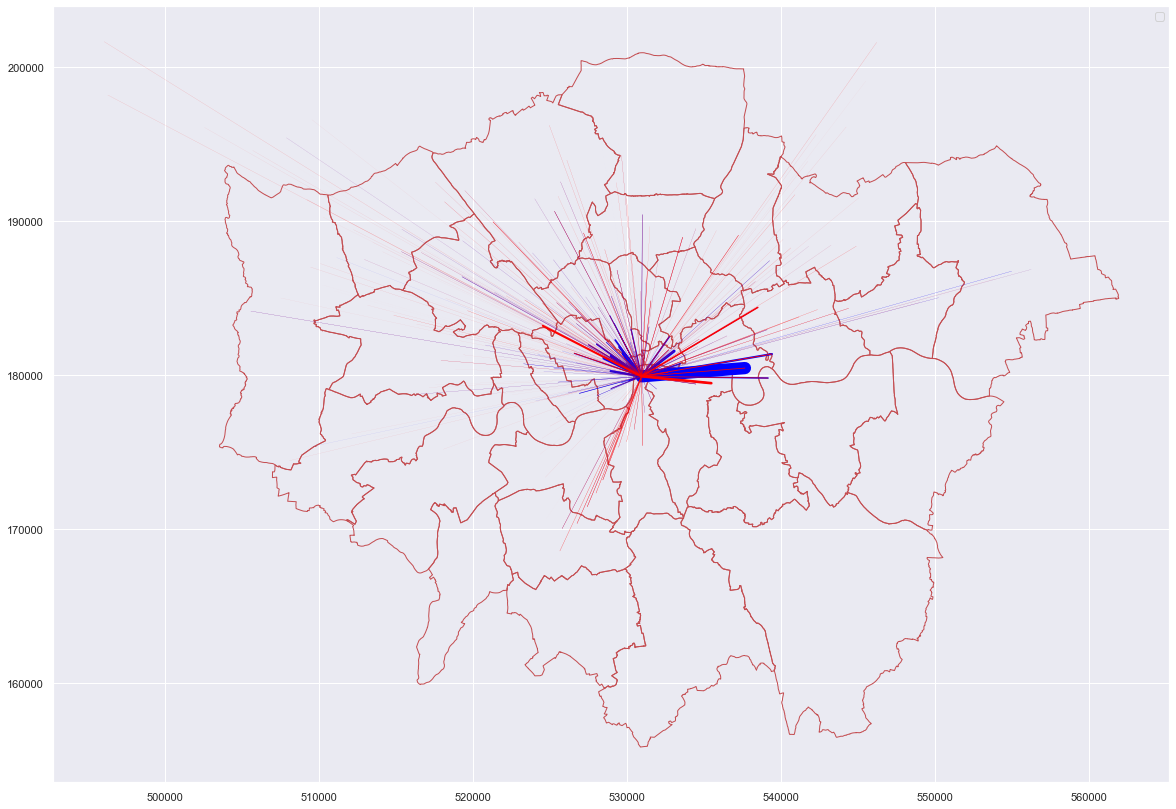

In [210]:
London.plot(figsize = (20,30), facecolor = "None", edgecolor = "r")

for i in range(0,len(combined_echo)):
    x1 = [combined_echo['orig_x'][i],  combined_echo['dest_x'][i]]
    y1 = [combined_echo['orig_y'][i],  combined_echo['dest_y'][i]]
    tmp_fsip = combined_echo['ampeak_flows'][i]
    
    
    #print(fsip_ampeak_workandedu, max(od_matrix_cleaned["place_based_fsip(other)"]))
    if(combined_echo['station_origin'][i] == 'Waterloo'):
        plt.plot(x1, y1, linewidth=(tmp_fsip / max(combined_echo['ampeak_flows']))*25, color='Blue',alpha=1.0)
        #print('echo1', (tmp_fsip / max(combined_echo['ampeak_flows'])))
    elif(combined_echo['station_destination'][i] == 'Waterloo'):
        plt.plot(x1, y1, linewidth=(tmp_fsip / max(combined_echo['ampeak_flows']))*25, color='Red',alpha=1.0)
        #print('echo2', (tmp_fsip / max(combined_echo['ampeak_flows'])))


legend = plt.legend()

plt.savefig('./figure/Waterloo.png')
# 显示地图
plt.show()

TypeError: unsupported operand type(s) for -: 'str' and 'str'

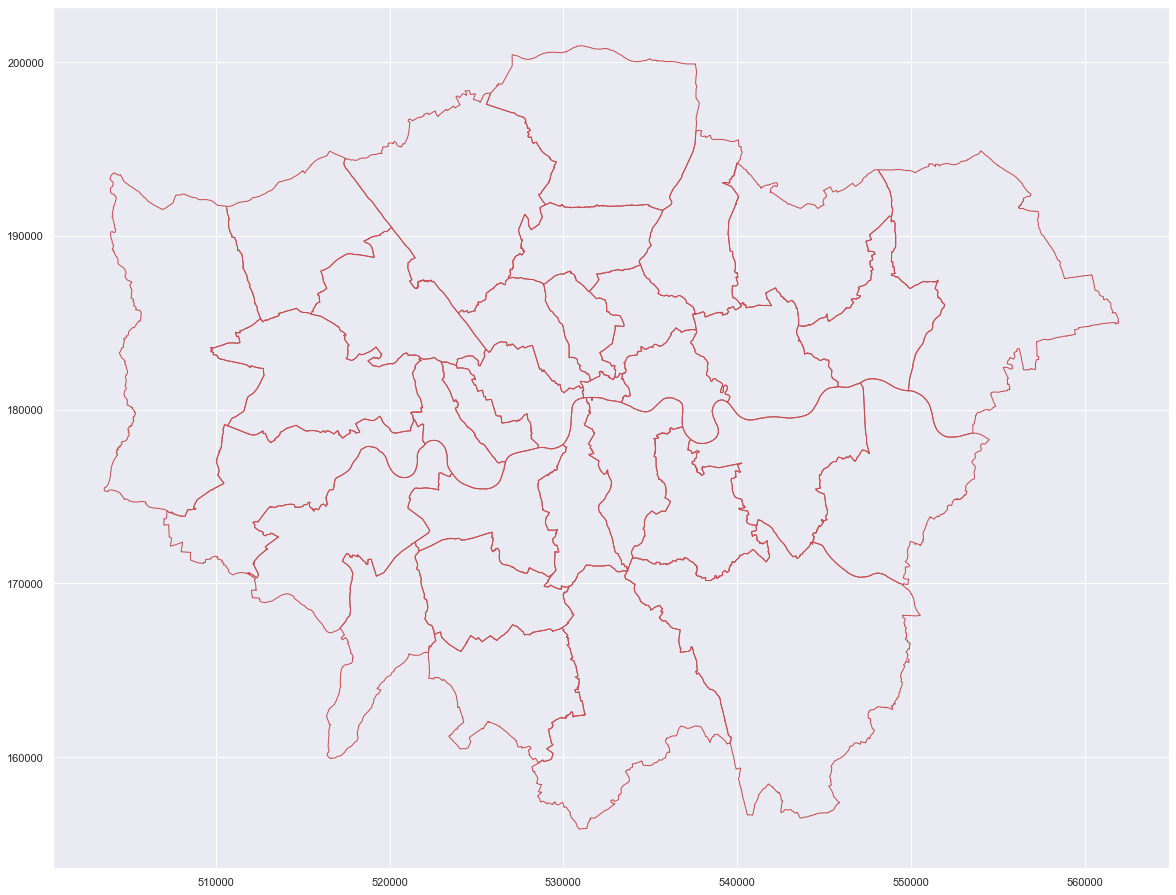

In [164]:
London.plot(figsize = (20,30), facecolor = "None", edgecolor = "r")
odmatrix_vis(od_matrix_cleaned, "fsip_2work")

In [ ]:
def odmatrix_vis(od_df, col_name):
    for i in range(0,len(od_df)):
        x1 = [od_df['orig_x'][i],  od_df['dest_x'][i]]
        y1 = [od_df['orig_y'][i],  od_df['dest_y'][i]]
        tmp_fsip = od_df[col_name][i]
        # 绘制线条并设置宽度
        quan_25 = od_df[col_name].quantile(0.2)
        quan_50 = od_df[col_name].quantile(0.5)
        quan_75 = od_df[col_name].quantile(0.8)
        quan_100 = max(od_df[col_name])


        #print(fsip_ampeak_workandedu, max(od_matrix_cleaned["place_based_fsip(other)"]))
        if(quan_75 < tmp_fsip <= quan_100):
            plt.plot(x1, y1, linewidth=tmp_fsip / max(od_df[col_name]), color='Blue',alpha=1.0)

        elif(quan_50 < tmp_fsip <= quan_75):
            plt.plot(x1, y1, linewidth=(tmp_fsip / max(od_df[col_name])), color="Green",alpha=1.0)

        elif(quan_25 < tmp_fsip <= quan_50):
            plt.plot(x1, y1, linewidth=(tmp_fsip / max(od_df[col_name])), color="Red",alpha=1.0)

        elif(tmp_fsip <= quan_25):
            plt.plot(x1, y1, linewidth=(tmp_fsip / max(od_df[col_name])), color="magenta",alpha=1.0)

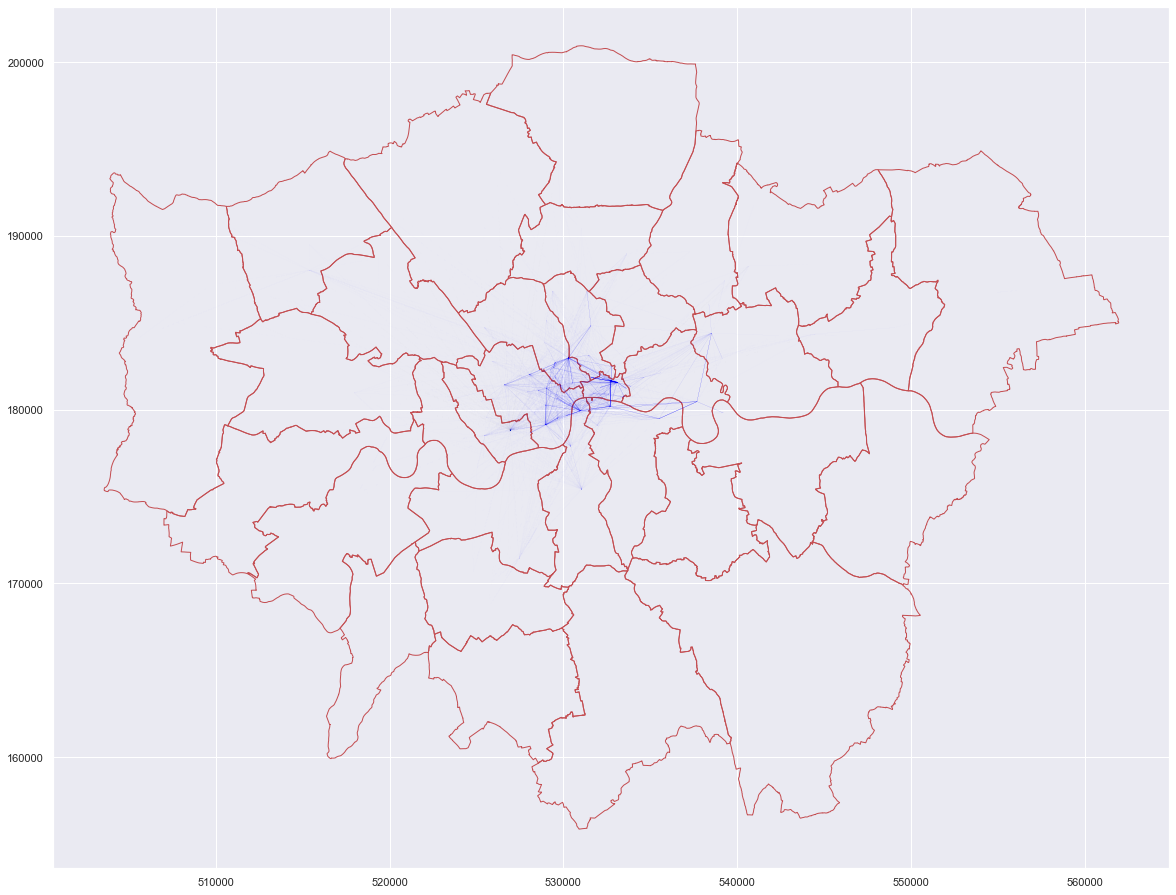

In [57]:
#plot the base map
# London.plot(figsize = (20,30), facecolor = "None", edgecolor = "r")
# odmatrix_vis(od_matrix_cleaned, "fsip_2work")

#### Calculate the absolute attribute ( To Education (Concentration))

In [61]:
# 代码块开始之前记录开始时间
start_time = time.time()

for i in range(0,len(od_matrix_cleaned)):
    # 找寻所有邻居，邻居定义为首尾相连的flow
    tmp_station = od_matrix_cleaned['station_origin'][i]
    tmp_row = od_matrix_cleaned.iloc[[i]]
    #tmp_df = pd.DataFrame()
    tmp_fsip = 0
    tmp_distance=0
    
    #tmp_df = pd.DataFrame(columns=['station_name', 'total_flows', 'orig_x','orig_y','dest_x','dest_y'])
    
    tmp_df1 = od_matrix_cleaned[od_matrix_cleaned['station_origin'] == tmp_station]
    tmp_df2 = od_matrix_cleaned[od_matrix_cleaned['station_destination'] == tmp_station]
    
    tmp_df = pd.concat([tmp_df1,tmp_df2])
    tmp_df.reset_index(drop=True, inplace=True)
    
    # 将新的数据行加入到DataFrame的第一行
    tmp_row_df = pd.DataFrame(tmp_row)
    tmp_df = pd.concat([tmp_row_df, tmp_df], ignore_index=True)
    
    # 2.按照公式计算出$I_{(ij)}$ (每个flow和它的所有邻居一起计算)
    for j in range(1,len(tmp_df)):
        tmp_distance = distance_decay_function(tmp_df['orig_x'][0],tmp_df['orig_y'][0],
                                tmp_df['orig_x'][0],tmp_df['orig_y'][0],
                                tmp_df['dest_x'][0],tmp_df['dest_y'][0],
                                tmp_df['dest_x'][j],tmp_df['dest_y'][j])
        tmp_fsip += tmp_df['ampeak_2edu_flows'][0] * tmp_df['ampeak_2edu_flows'][j] * tmp_distance

    od_matrix_cleaned.at[i, 'fsip_2edu'] = tmp_fsip

# 代码块开始之前记录开始时间
end_time = time.time()

In [62]:
# 计算运行时间差
execution_time = end_time - start_time
print(f"代码块的运行时间：{execution_time} 秒")

代码块的运行时间：611.9205708503723 秒


**Visualization**

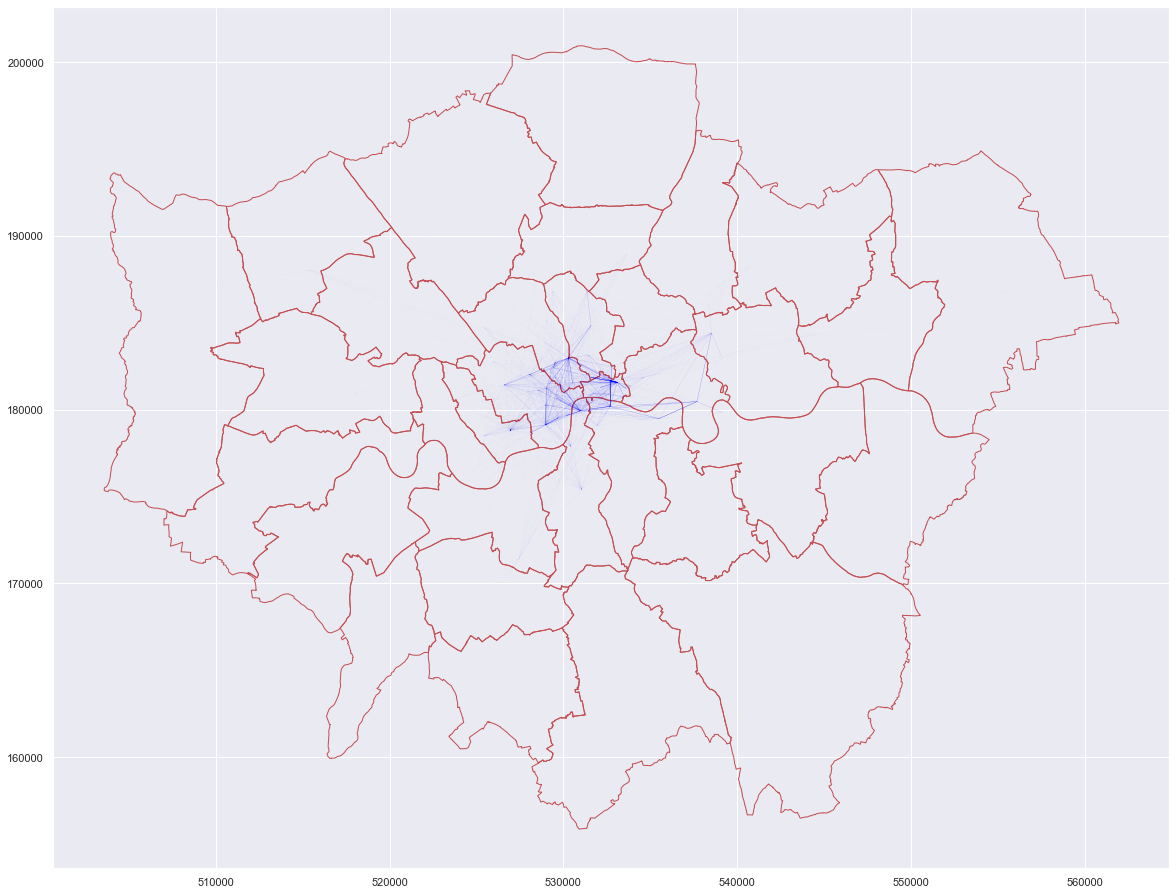

In [60]:
#plot the base map
# London.plot(figsize = (20,30), facecolor = "None", edgecolor = "r")
# odmatrix_vis(od_matrix_cleaned, "fsip_2edu")

#### Calculate the absolute attribute (To Other (Concentration)))

In [63]:
# 代码块开始之前记录开始时间
start_time = time.time()

for i in range(0,len(od_matrix_cleaned)):
    # 找寻所有邻居，邻居定义为首尾相连的flow
    tmp_station = od_matrix_cleaned['station_origin'][i]
    tmp_row = od_matrix_cleaned.iloc[[i]]
    #tmp_df = pd.DataFrame()
    tmp_fsip = 0
    tmp_distance=0
    
    #tmp_df = pd.DataFrame(columns=['station_name', 'total_flows', 'orig_x','orig_y','dest_x','dest_y'])
    
    tmp_df1 = od_matrix_cleaned[od_matrix_cleaned['station_origin'] == tmp_station]
    tmp_df2 = od_matrix_cleaned[od_matrix_cleaned['station_destination'] == tmp_station]
    
    tmp_df = pd.concat([tmp_df1,tmp_df2])
    tmp_df.reset_index(drop=True, inplace=True)
    
    # 将新的数据行加入到DataFrame的第一行
    tmp_row_df = pd.DataFrame(tmp_row)
    tmp_df = pd.concat([tmp_row_df, tmp_df], ignore_index=True)
    
    # 2.按照公式计算出$I_{(ij)}$ (每个flow和它的所有邻居一起计算)
    for j in range(1,len(tmp_df)):
        tmp_distance = distance_decay_function(tmp_df['orig_x'][0],tmp_df['orig_y'][0],
                                tmp_df['orig_x'][0],tmp_df['orig_y'][0],
                                tmp_df['dest_x'][0],tmp_df['dest_y'][0],
                                tmp_df['dest_x'][j],tmp_df['dest_y'][j])
        tmp_fsip += tmp_df['ampeak_2other_flows'][0] * tmp_df['ampeak_2other_flows'][j] * tmp_distance

    od_matrix_cleaned.at[i, 'fsip_2other'] = tmp_fsip

# 代码块开始之前记录开始时间
end_time = time.time()

In [64]:
# 计算运行时间差
execution_time = end_time - start_time
print(f"代码块的运行时间：{execution_time} 秒")

代码块的运行时间：603.558219909668 秒


**Visualization**

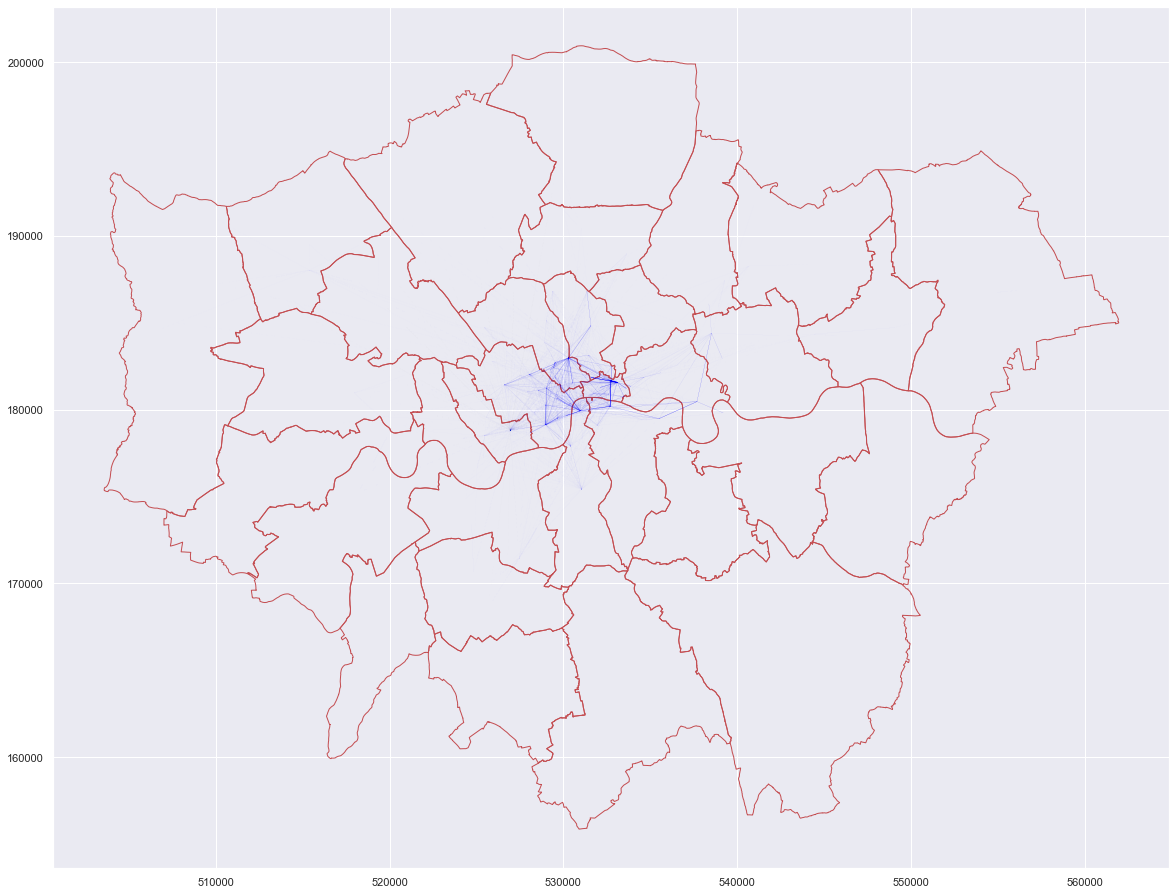

In [63]:
#plot the base map
# London.plot(figsize = (20,30), facecolor = "None", edgecolor = "r")
# odmatrix_vis(od_matrix_cleaned, "fsip_2other")

---

#### Calculate the absolute attribute (**To Work & To Education Interaction**)

In [65]:
# 代码块开始之前记录开始时间
start_time = time.time()

for i in range(0,len(od_matrix_cleaned)):
    # 找寻所有邻居，邻居定义为首尾相连的flow
    tmp_station = od_matrix_cleaned['station_origin'][i]
    tmp_row = od_matrix_cleaned.iloc[[i]]
    #tmp_df = pd.DataFrame()
    tmp_fsip = 0
    tmp_distance=0
    
    #tmp_df = pd.DataFrame(columns=['station_name', 'total_flows', 'orig_x','orig_y','dest_x','dest_y'])
    
    tmp_df1 = od_matrix_cleaned[od_matrix_cleaned['station_origin'] == tmp_station]
    tmp_df2 = od_matrix_cleaned[od_matrix_cleaned['station_destination'] == tmp_station]
    
    tmp_df = pd.concat([tmp_df1,tmp_df2])
    tmp_df.reset_index(drop=True, inplace=True)
    
    # 将新的数据行加入到DataFrame的第一行
    tmp_row_df = pd.DataFrame(tmp_row)
    tmp_df = pd.concat([tmp_row_df, tmp_df], ignore_index=True)
    
    # 2.按照公式计算出$I_{(ij)}$ (每个flow和它的所有邻居一起计算)
    for j in range(1,len(tmp_df)):
        tmp_distance = distance_decay_function(tmp_df['orig_x'][0],tmp_df['orig_y'][0],
                                tmp_df['orig_x'][0],tmp_df['orig_y'][0],
                                tmp_df['dest_x'][0],tmp_df['dest_y'][0],
                                tmp_df['dest_x'][j],tmp_df['dest_y'][j])
        tmp_fsip += tmp_df['ampeak_2work_flows'][0] * tmp_df['ampeak_2edu_flows'][j] * tmp_distance + tmp_df['ampeak_2edu_flows'][0] * tmp_df['ampeak_2work_flows'][j] * tmp_distance

    od_matrix_cleaned.at[i, 'fsip_ampeak_workandedu'] = tmp_fsip

# 代码块开始之前记录开始时间
end_time = time.time()

**Visualization**

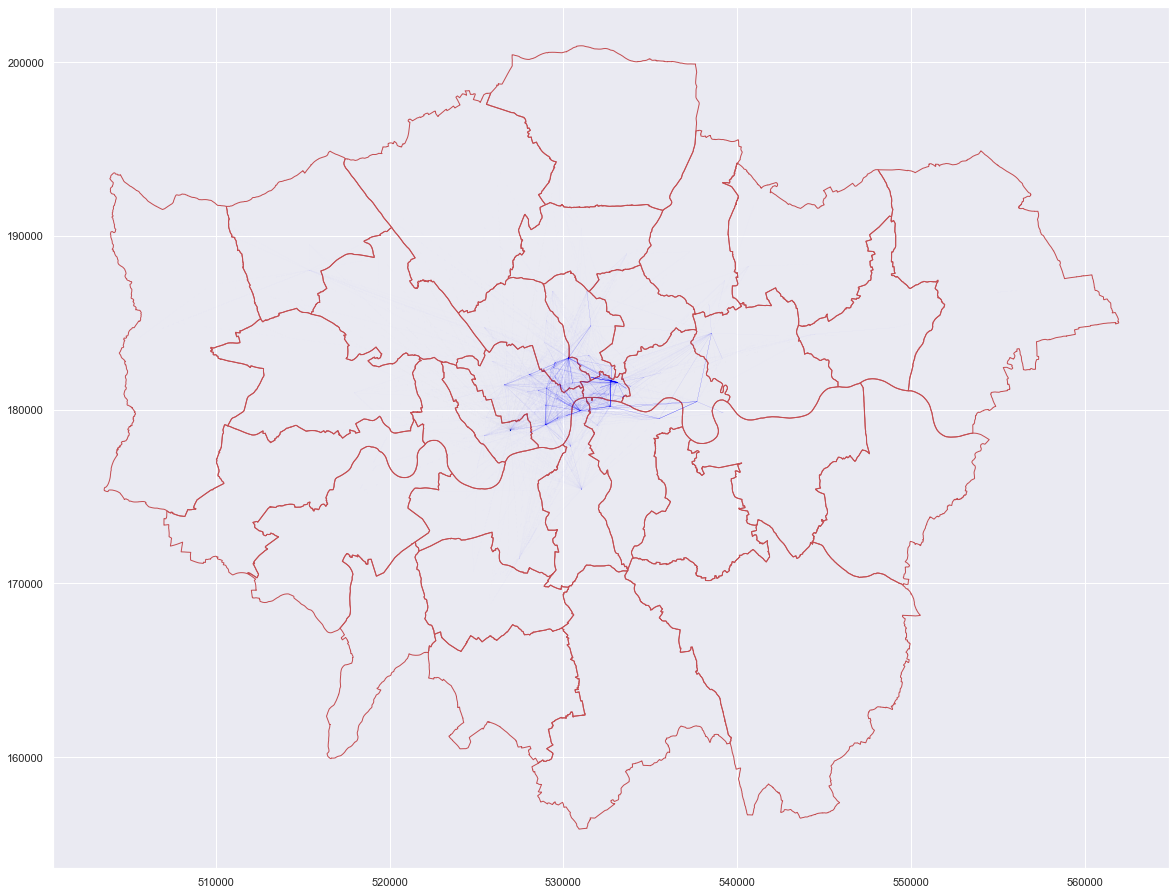

In [65]:
#plot the base map
# London.plot(figsize = (20,30), facecolor = "None", edgecolor = "r")
# odmatrix_vis(od_matrix_cleaned, "fsip_ampeak_workandedu")

#### Calculate the absolute attribute (**To Work & To To Other Interaction**)

In [66]:
# 代码块开始之前记录开始时间
start_time = time.time()

for i in range(0,len(od_matrix_cleaned)):
    # 找寻所有邻居，邻居定义为首尾相连的flow
    tmp_station = od_matrix_cleaned['station_origin'][i]
    tmp_row = od_matrix_cleaned.iloc[[i]]
    #tmp_df = pd.DataFrame()
    tmp_fsip = 0
    tmp_distance=0
    
    #tmp_df = pd.DataFrame(columns=['station_name', 'total_flows', 'orig_x','orig_y','dest_x','dest_y'])
    
    tmp_df1 = od_matrix_cleaned[od_matrix_cleaned['station_origin'] == tmp_station]
    tmp_df2 = od_matrix_cleaned[od_matrix_cleaned['station_destination'] == tmp_station]
    
    tmp_df = pd.concat([tmp_df1,tmp_df2])
    tmp_df.reset_index(drop=True, inplace=True)
    
    # 将新的数据行加入到DataFrame的第一行
    tmp_row_df = pd.DataFrame(tmp_row)
    tmp_df = pd.concat([tmp_row_df, tmp_df], ignore_index=True)
    #fsip_ampeak_eduandother
    # 2.按照公式计算出$I_{(ij)}$ (每个flow和它的所有邻居一起计算)
    for j in range(1,len(tmp_df)):
        tmp_distance = distance_decay_function(tmp_df['orig_x'][0],tmp_df['orig_y'][0],
                                tmp_df['orig_x'][0],tmp_df['orig_y'][0],
                                tmp_df['dest_x'][0],tmp_df['dest_y'][0],
                                tmp_df['dest_x'][j],tmp_df['dest_y'][j])
        tmp_fsip += tmp_df['ampeak_2work_flows'][0] * tmp_df['ampeak_2other_flows'][j] * tmp_distance + tmp_df['ampeak_2other_flows'][0] * tmp_df['ampeak_2work_flows'][j] * tmp_distance

    od_matrix_cleaned.at[i, 'fsip_ampeak_workandother'] = tmp_fsip

# 代码块开始之前记录开始时间
end_time = time.time()

**Visualization**

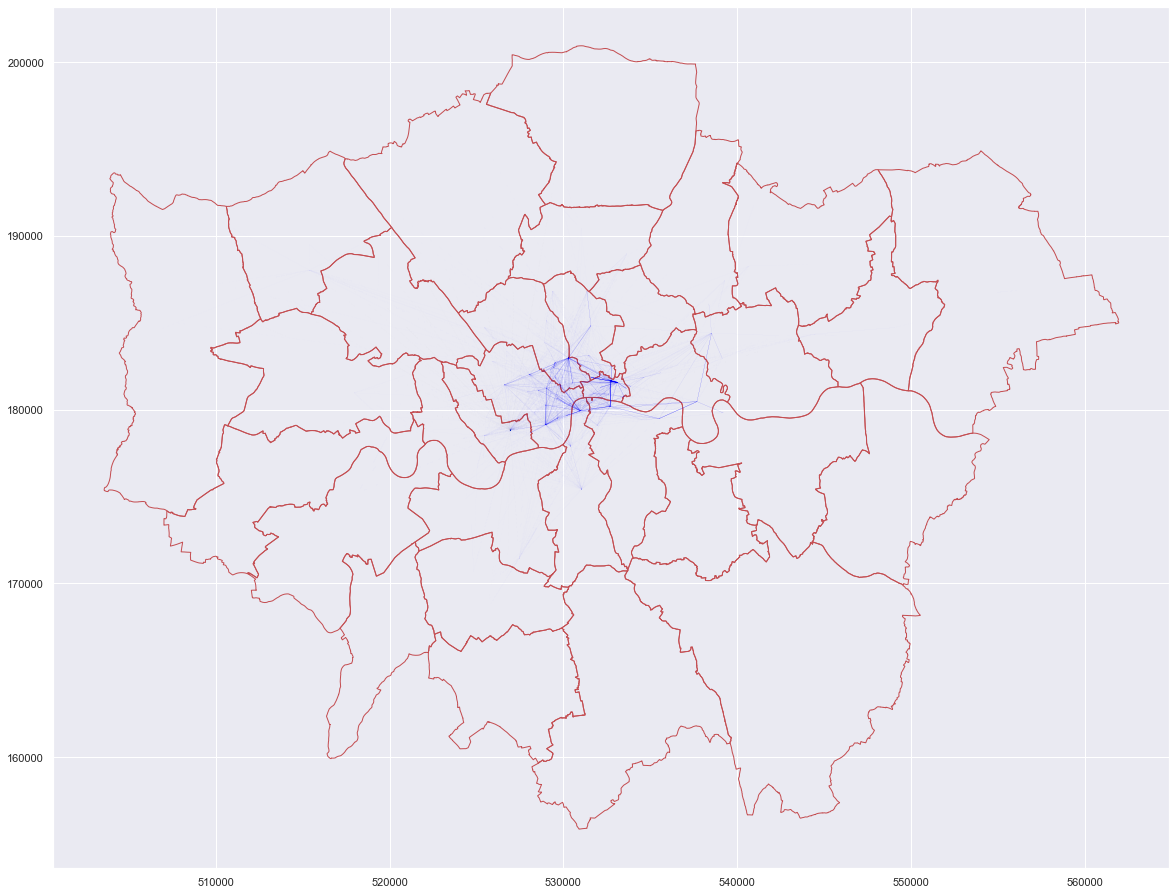

In [70]:
#plot the base map
# London.plot(figsize = (20,30), facecolor = "None", edgecolor = "r")
# odmatrix_vis(od_matrix_cleaned, "fsip_ampeak_workandother")

#### Calculate the absolute attribute (**To Education & To To Other Interaction**)

In [67]:
# 代码块开始之前记录开始时间
start_time = time.time()

for i in range(0,len(od_matrix_cleaned)):
    # 找寻所有邻居，邻居定义为首尾相连的flow
    tmp_station = od_matrix_cleaned['station_origin'][i]
    tmp_row = od_matrix_cleaned.iloc[[i]]
    #tmp_df = pd.DataFrame()
    tmp_fsip = 0
    tmp_distance=0
    
    #tmp_df = pd.DataFrame(columns=['station_name', 'total_flows', 'orig_x','orig_y','dest_x','dest_y'])
    
    tmp_df1 = od_matrix_cleaned[od_matrix_cleaned['station_origin'] == tmp_station]
    tmp_df2 = od_matrix_cleaned[od_matrix_cleaned['station_destination'] == tmp_station]
    
    tmp_df = pd.concat([tmp_df1,tmp_df2])
    tmp_df.reset_index(drop=True, inplace=True)
    
    # 将新的数据行加入到DataFrame的第一行
    tmp_row_df = pd.DataFrame(tmp_row)
    tmp_df = pd.concat([tmp_row_df, tmp_df], ignore_index=True)
    
    # 2.按照公式计算出$I_{(ij)}$ (每个flow和它的所有邻居一起计算)
    for j in range(1,len(tmp_df)):
        tmp_distance = distance_decay_function(tmp_df['orig_x'][0],tmp_df['orig_y'][0],
                                tmp_df['orig_x'][0],tmp_df['orig_y'][0],
                                tmp_df['dest_x'][0],tmp_df['dest_y'][0],
                                tmp_df['dest_x'][j],tmp_df['dest_y'][j])
        tmp_fsip += tmp_df['ampeak_2edu_flows'][0] * tmp_df['ampeak_2other_flows'][j] * tmp_distance + tmp_df['ampeak_2other_flows'][0] * tmp_df['ampeak_2edu_flows'][j] * tmp_distance

    od_matrix_cleaned.at[i, 'fsip_ampeak_eduandother'] = tmp_fsip

# 代码块开始之前记录开始时间
end_time = time.time()

**Visualization**

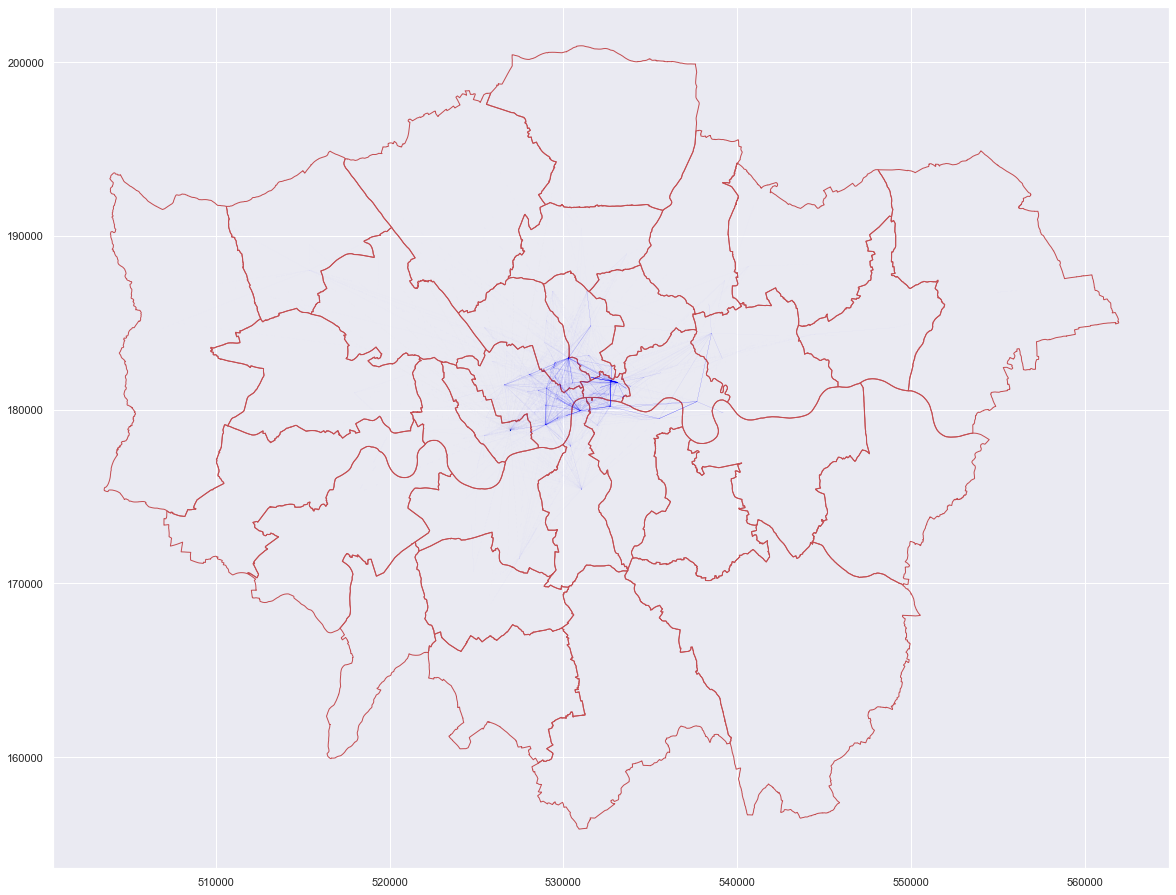

In [72]:
#plot the base map
# London.plot(figsize = (20,30), facecolor = "None", edgecolor = "r")
# odmatrix_vis(od_matrix_cleaned, "fsip_ampeak_eduandother")

### Normalisation of the flow-based spatial interaction potential - relative measures

**Concentration Formula**

We can also normalise the concentration measurement in a similar way. The value of this score is also between 0 and 1. This score is the flow-based isolation measure, and the larget this value is, the greater the extent to which this group of people is segregated or iolated form others

$$\tag{13}\bar{I}_{(ij)}^{k} = \frac{I_{(ij)}^k}{I_{i'j'}} = \frac{\Sigma_{(i'j')}P_{(ij)}^kP_{(i'j')}^ke^{-\beta d_{(ij,i'j')}}}{\Sigma_{(i'j')}P_{(ij)}P_{(i'j')}e^{-\beta d_{(ij,i'j')}}}$$

#### Calculate the relative form of 2work(Concentration)

In [68]:
od_matrix_cleaned['fsip_2work(relative)'] = np.where(
    od_matrix_cleaned['fsip_ampeak'] == 0, 0, 
    od_matrix_cleaned['fsip_2work'] / od_matrix_cleaned['fsip_ampeak']
)

**Visualization**

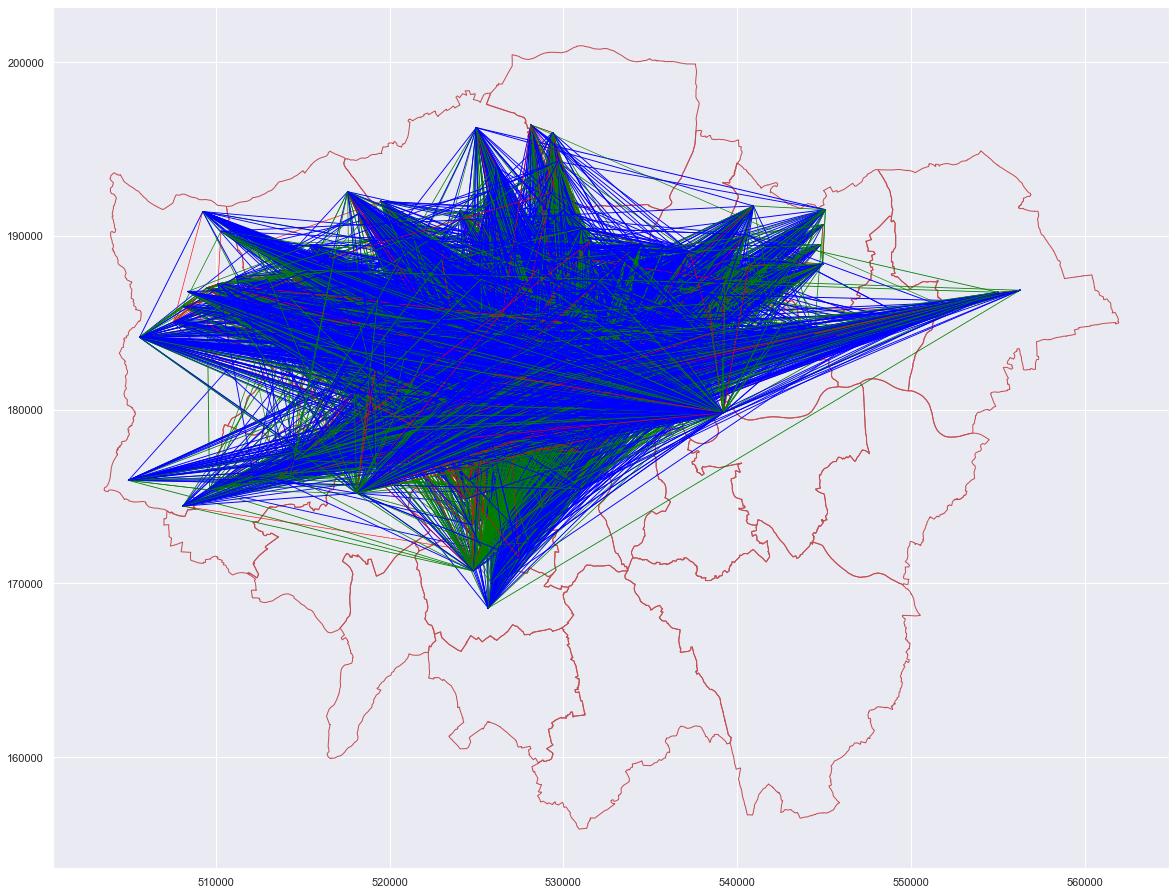

In [74]:
#plot the base map
# London.plot(figsize = (20,30), facecolor = "None", edgecolor = "r")
# odmatrix_vis(od_matrix_cleaned, "fsip_2work(relative)")

#### Calculate the relative form of 2edu(Concentration)

In [69]:
od_matrix_cleaned['fsip_2edu(relative)'] = np.where(
    od_matrix_cleaned['fsip_ampeak'] == 0, 0, 
    od_matrix_cleaned['fsip_2edu'] / od_matrix_cleaned['fsip_ampeak']
)

**Visualization**

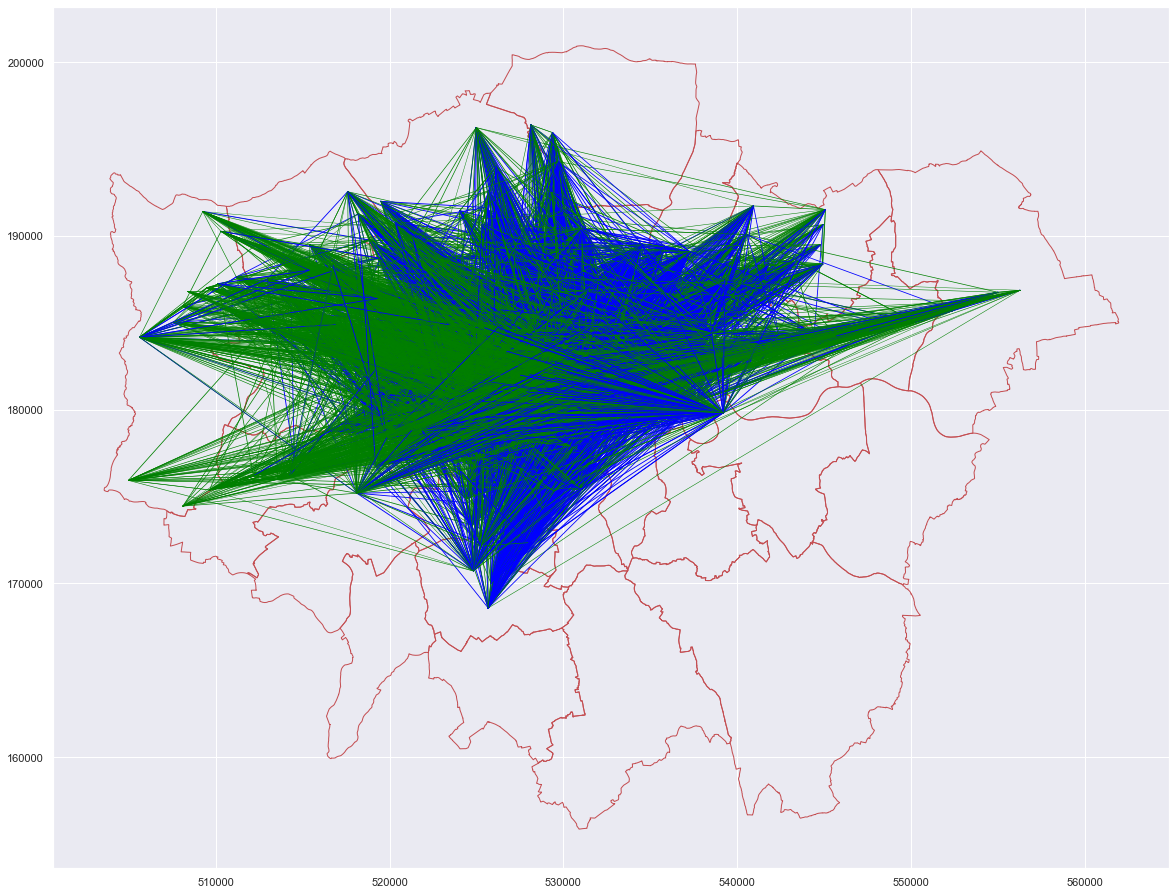

In [76]:
#plot the base map
# London.plot(figsize = (20,30), facecolor = "None", edgecolor = "r")
# odmatrix_vis(od_matrix_cleaned, "fsip_2edu(relative)")

#### Calculate the relative form of 2otherConcentration)

In [70]:
od_matrix_cleaned['fsip_2other(relative)'] = np.where(
    od_matrix_cleaned['fsip_ampeak'] == 0, 0, 
    od_matrix_cleaned['fsip_2other'] / od_matrix_cleaned['fsip_ampeak']
)

**Visualization**

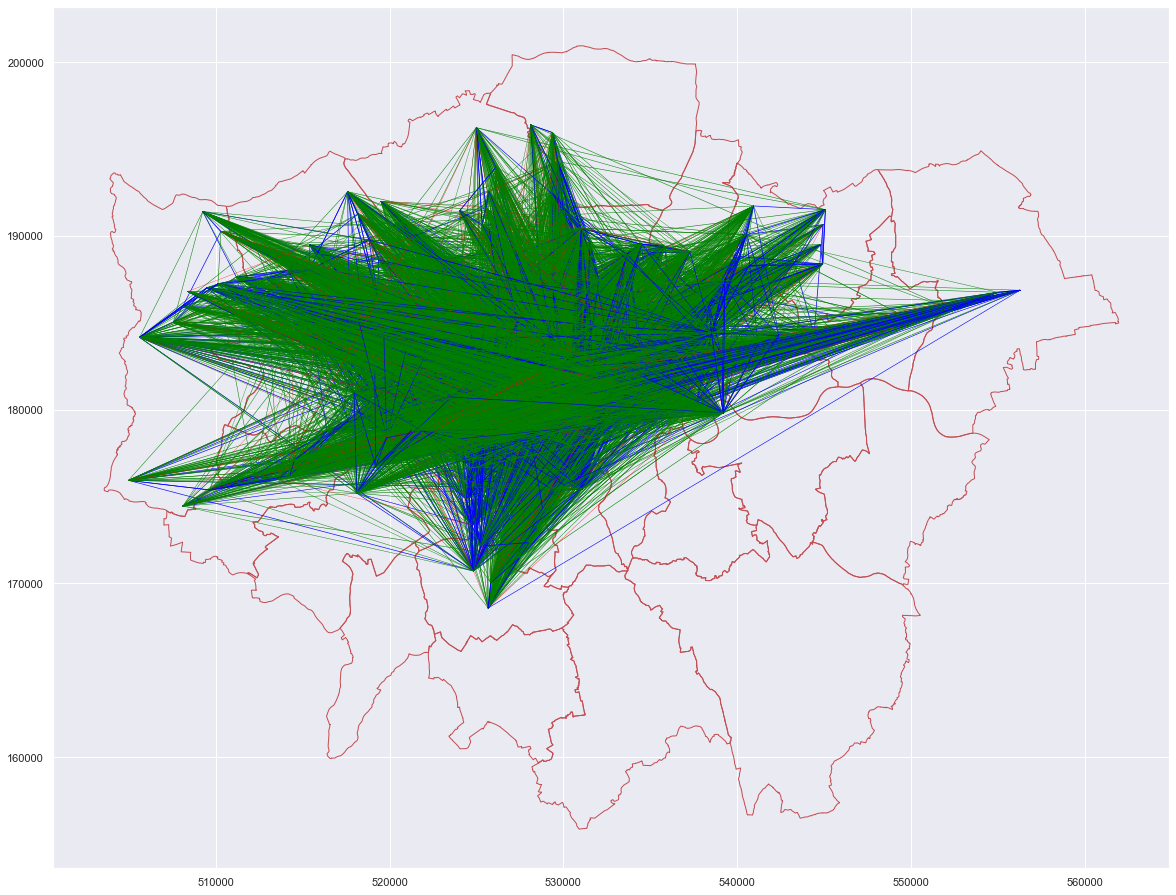

In [78]:
#plot the base map
# London.plot(figsize = (20,30), facecolor = "None", edgecolor = "r")
# odmatrix_vis(od_matrix_cleaned, "fsip_2other(relative)")

We can transform the inflow and outflow spatial interaction potentials in similar ways, as shown below. In Eqs. $(14) and (15)$, we show the ways to normalise the outflow flow-based interaction between group $k$ and $l$ and the outflow flow-based concentration for gourp $k$. Aggregating these flow-based interaction by their destinations, we can obtain place-based outputs characterised by the inflow-based spatial interactions

**Relative FSIP between groups formula**

This flow-based exposure index is a relative form, representing the extent to which the spatial interactions between flows in groups contribute to the interaction between all flows. The larget this value is, the greater the number of potential interactions that could happen between the commuting routes for the travelers in these two groups

$$\tag{12}\bar{I}_{(ij)}^{k|l} = \frac{I_{(ij)}^{k|l}}{I_{(ij)}} = \frac{\Sigma_{(i'j')}P_{(ij)}^kP_{(i'j')}^le^{-\beta d_{(ij,i'j')}} + \Sigma_{(i'j')}P_{(ij)}^lP_{(i'j')}^ke^{-\beta d_{(ij,i'j')}}}{P_{ij}P_{i'j'}*e^{-\beta d_{(ij,i'j')}}}$$

From                                      0
station_origin                            0
To                                        0
station_destination                       0
early_flows                               0
ampeak_flows                              0
midday_flows                              0
pmpeak_flows                              0
evening_flows                             0
late_flows                                0
total_flows                               0
orig_x                                    0
orig_y                                    0
dest_x                                    0
dest_y                                    0
orig_coord_lat                            0
orig_coord_lon                            0
dest_coord_lat                            0
dest_coord_lon                            0
fsip                                      0
fsip_ampeak                               0
station_dis                               0
ampeak_2work_flows              

#### Calculate the relative form between 2work and 2edu

In [71]:
od_matrix_cleaned['fsip_ampeak_workandedu(relative)'] = np.where(
    od_matrix_cleaned['fsip_ampeak'] == 0, 0, 
    od_matrix_cleaned['fsip_ampeak_workandedu'] / od_matrix_cleaned['fsip_ampeak']
)

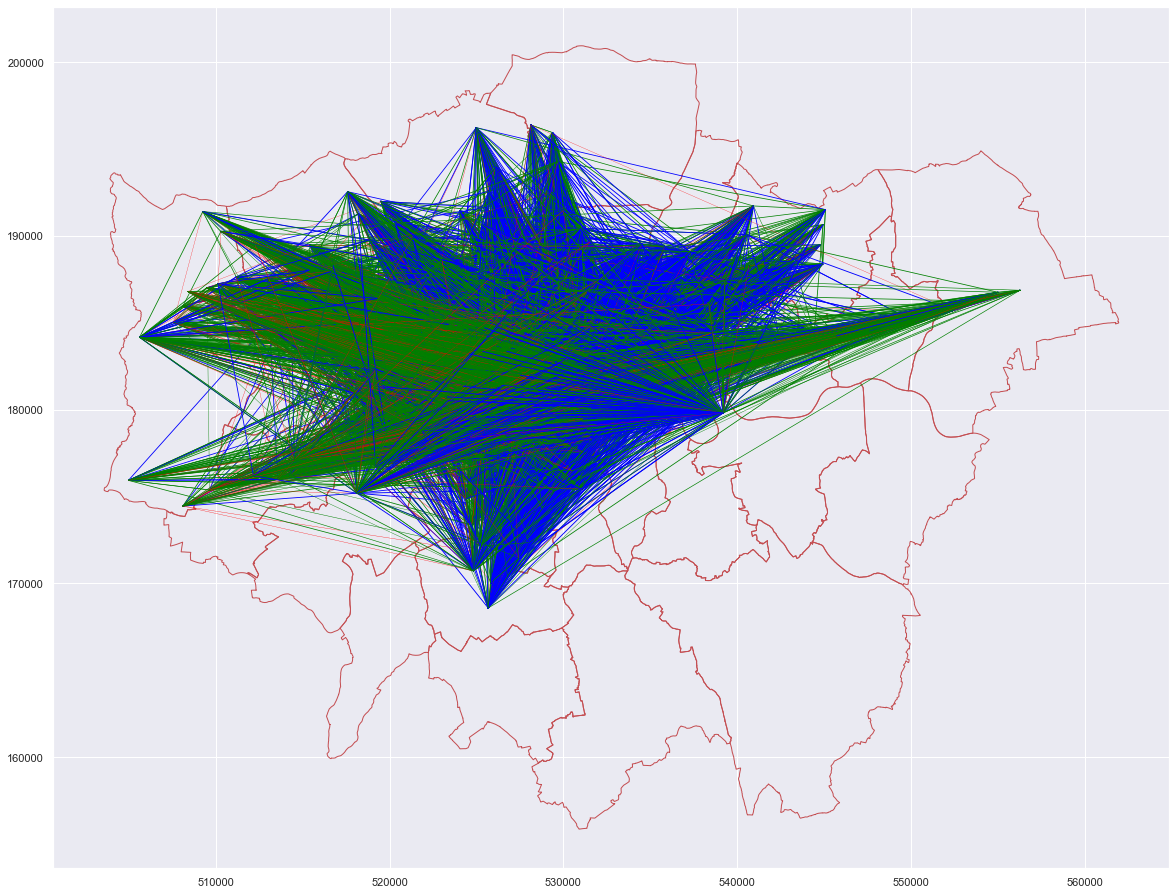

In [80]:
#plot the base map
# London.plot(figsize = (20,30), facecolor = "None", edgecolor = "r")
# odmatrix_vis(od_matrix_cleaned, "fsip_ampeak_workandedu(relative)")

#### Calculate the relative form between 2edu and 2other

In [145]:
od_matrix_cleaned['fsip_ampeak_eduandother(relative)'] = np.where(
    od_matrix_cleaned['fsip_ampeak'] == 0, 0, 
    od_matrix_cleaned['fsip_ampeak_eduandother'] / od_matrix_cleaned['fsip_ampeak']
)

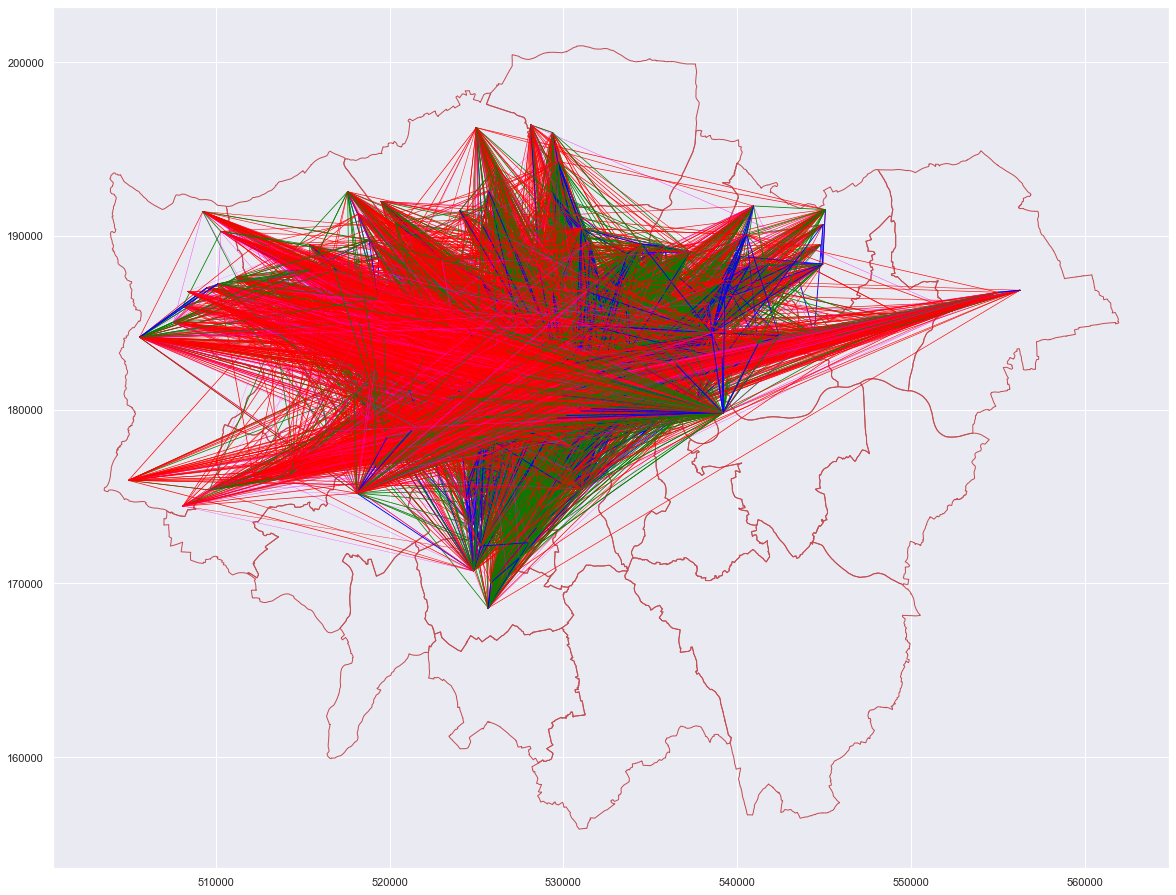

In [82]:
#plot the base map
# London.plot(figsize = (20,30), facecolor = "None", edgecolor = "r")
# odmatrix_vis(od_matrix_cleaned, "fsip_ampeak_eduandother(relative)")

#### Calculate the relative form between 2work and 2other

In [146]:
od_matrix_cleaned['fsip_ampeak_workandother(relative)'] = np.where(
    od_matrix_cleaned['fsip_ampeak'] == 0, 0, 
    od_matrix_cleaned['fsip_ampeak_workandother'] / od_matrix_cleaned['fsip_ampeak']
)

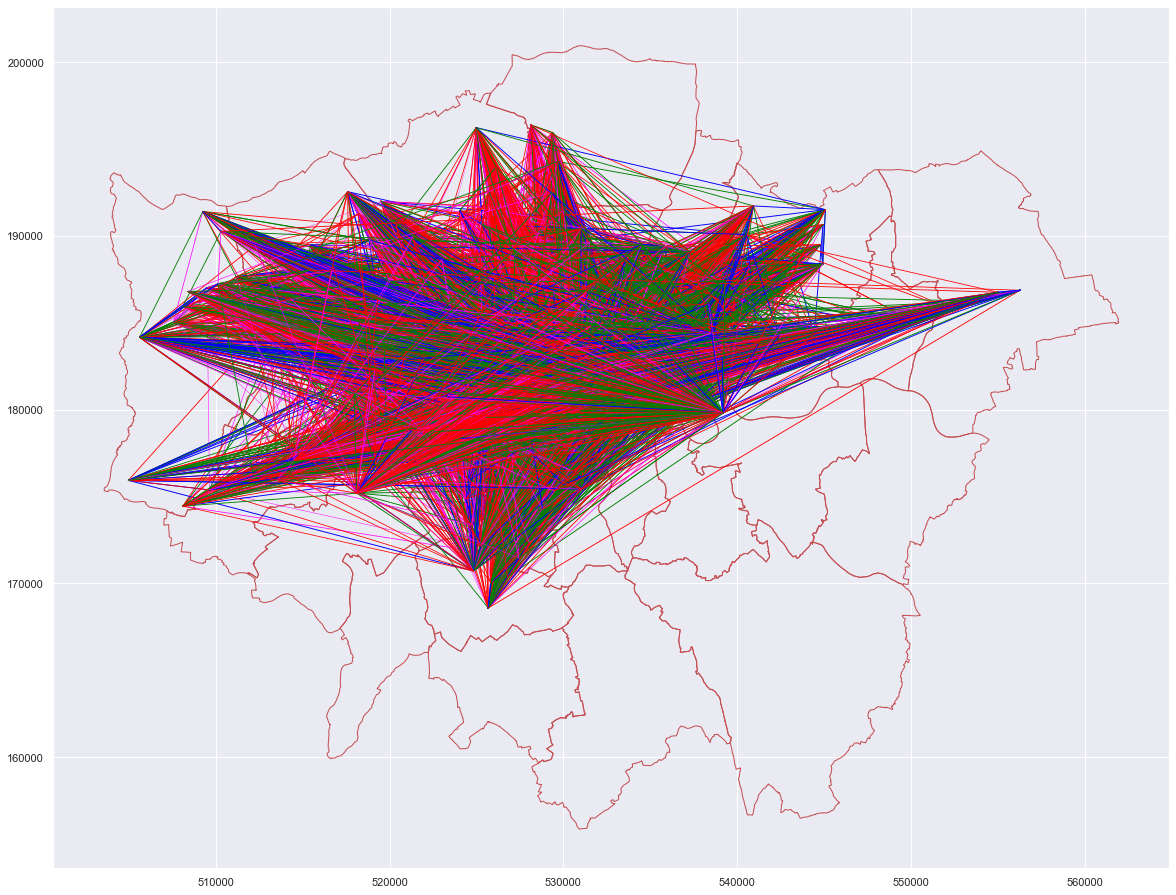

In [84]:
#plot the base map
# London.plot(figsize = (20,30), facecolor = "None", edgecolor = "r")
# odmatrix_vis(od_matrix_cleaned, "fsip_ampeak_workandother(relative)")

### Place-based metrix

The place-based metrics:
    
$$ P_{pb} = \bar{I}_i^k / \bar{I}_j^k $$

The normalised $FSIP$ score for group $k$ traveling from place $i$ / to place $j$

#### 2Wrok Group Place-based Metrix

In [92]:
stations_list = od_matrix_cleaned['station_origin'].unique()
tmp_inflow, tmp_outflow = 0,0


for i in range(0,len(stations_list)):
    #print(od_matrix_cleaned[od_matrix_cleaned['station_origin'] == stations_list[i]]['fsip'])
    tmp_outflow_set = set(od_matrix_cleaned[od_matrix_cleaned['station_origin'] == stations_list[i]]['fsip_2work(relative)'])
    tmp_outflow = sum(tmp_outflow_set)
    
    od_matrix_cleaned.loc[od_matrix_cleaned['station_origin'] == stations_list[i], 'relative_outflow(work)'] = tmp_outflow

    tmp_inflow_set = set(od_matrix_cleaned[od_matrix_cleaned['station_destination'] == stations_list[i]]['fsip_2work(relative)'])
    tmp_inflow = sum(tmp_inflow_set)
    
    od_matrix_cleaned.loc[od_matrix_cleaned['station_destination'] == stations_list[i], 'relative_inflow(work)'] = tmp_inflow
    
od_matrix_cleaned['place_based_fsip(work)'] = np.where(
    od_matrix_cleaned['relative_inflow(work)'] == 0, 0, 
    od_matrix_cleaned['relative_outflow(work)'] / od_matrix_cleaned['relative_inflow(work)'])     

In [95]:
# 假设你有一个名为 df 的 DataFrame，column1 是需要根据其值进行操作的列，column2 是需要进行操作的目标列
def operation_based_on_work(row):
    if row['ampeak_flows'] == 0:
        return 0
    else:
        return row['place_based_fsip(work)']

od_matrix_cleaned['place_based_fsip(work)'] = od_matrix_cleaned.apply(operation_based_on_work, axis=1)

In [75]:
od_matrix_cleaned[['station_origin','station_destination','place_based_fsip(work)']]

station_origin station_destination  place_based_fsip(work)
0           Acton Town            Alperton                2.346966
1           Acton Town               Angel                0.490633
2           Acton Town             Archway                1.024093
3           Acton Town             Arsenal                5.533111
4           Acton Town        Baker Street                0.422602
...                ...                 ...                     ...
30229  North Greenwich           Wimbledon                2.506160
30230  North Greenwich          Wood Green                2.090450
30231  North Greenwich           Wood Lane                6.984055
30232  North Greenwich            Woodford                8.314201
30233  North Greenwich       Woodside Park                6.552963

[30234 rows x 3 columns]

**Visualization**

In [ ]:
# #plot the base map
# London.plot(figsize = (20,30), facecolor = "None", edgecolor = "r")
# odmatrix_vis(od_matrix_cleaned, "place_based_fsip(work)")

#### 2Edu Group Place-based Metrix

In [76]:
stations_list = od_matrix_cleaned['station_origin'].unique()
tmp_inflow, tmp_outflow = 0,0


for i in range(0,len(stations_list)):
    #print(od_matrix_cleaned[od_matrix_cleaned['station_origin'] == stations_list[i]]['fsip'])
    tmp_outflow_set = set(od_matrix_cleaned[od_matrix_cleaned['station_origin'] == stations_list[i]]['fsip_2edu(relative)'])
    tmp_outflow = sum(tmp_outflow_set)
    
    od_matrix_cleaned.loc[od_matrix_cleaned['station_origin'] == stations_list[i], 'relative_outflow(edu)'] = tmp_outflow

    tmp_inflow_set = set(od_matrix_cleaned[od_matrix_cleaned['station_destination'] == stations_list[i]]['fsip_2edu(relative)'])
    tmp_inflow = sum(tmp_inflow_set)
    
    od_matrix_cleaned.loc[od_matrix_cleaned['station_destination'] == stations_list[i], 'relative_inflow(edu)'] = tmp_inflow

od_matrix_cleaned['place_based_fsip(edu)'] = np.where(
    od_matrix_cleaned['relative_inflow(edu)'] == 0, 0, 
    od_matrix_cleaned['relative_outflow(edu)'] / od_matrix_cleaned['relative_inflow(edu)'])  

In [77]:
# 假设你的DataFrame为df，column_name为要处理的列名，threshold为阈值
threshold = 100  # 根据数据情况设置合适的阈值
od_matrix_cleaned.loc[od_matrix_cleaned['place_based_fsip(edu)'] > threshold, 'place_based_fsip(edu)'] = 0

In [96]:
# 假设你有一个名为 df 的 DataFrame，column1 是需要根据其值进行操作的列，column2 是需要进行操作的目标列
def operation_based_on_edu(row):
    if row['ampeak_flows'] == 0:
        return 0
    else:
        return row['place_based_fsip(edu)']

od_matrix_cleaned['place_based_fsip(edu)'] = od_matrix_cleaned.apply(operation_based_on_edu, axis=1)

**Visulization**

In [ ]:
# #plot the base map
# London.plot(figsize = (20,30), facecolor = "None", edgecolor = "r")
# odmatrix_vis(od_matrix_cleaned, "place_based_fsip(edu)")

In [110]:
stations_list

array(['Acton Town', 'Boston Manor', 'Chiswick Park', 'Ealing Broadway',
       'Ealing Common', 'Greenford', 'Hanger Lane', 'North Acton',
       'North Ealing', 'Northfields', 'Northolt', 'Park Royal',
       'Perivale', 'South Ealing', 'Sudbury Town', 'Turnham Green',
       'West Acton', 'Aldgate', 'Blackfriars', 'Cannon Street',
       'Liverpool Street', 'Mansion House', 'Moorgate', "St. Paul's",
       'Tower Hill', 'Aldgate East', 'Bethnal Green', 'Bow Road',
       'Bromley-by-Bow', 'Canary Wharf', 'Mile End', 'Stepney Green',
       'Whitechapel', 'Alperton', 'Dollis Hill', 'Harlesden',
       'Kensal Green', 'Kilburn', 'Kilburn Park', 'Kingsbury', 'Neasden',
       'North Wembley', 'Northwick Park', 'Preston Road', "Queen's Park",
       'South Kenton', 'Stonebridge Park', 'Wembley Central',
       'Wembley Park', 'Willesden Green', 'Willesden Junction', 'Angel',
       'Archway', 'Arsenal', 'Barbican', 'Caledonian Road',
       'Finsbury Park', 'Highbury & Islington', 'Holl

#### 2Other Group Place-based Metrix

In [78]:
stations_list = od_matrix_cleaned['station_origin'].unique()
tmp_inflow, tmp_outflow = 0,0


for i in range(0,len(stations_list)):
    #print(od_matrix_cleaned[od_matrix_cleaned['station_origin'] == stations_list[i]]['fsip'])
    tmp_outflow_set = set(od_matrix_cleaned[od_matrix_cleaned['station_origin'] == stations_list[i]]['fsip_2other(relative)'])
    tmp_outflow = sum(tmp_outflow_set)
    
    od_matrix_cleaned.loc[od_matrix_cleaned['station_origin'] == stations_list[i], 'relative_outflow(other)'] = tmp_outflow

    tmp_inflow_set = set(od_matrix_cleaned[od_matrix_cleaned['station_destination'] == stations_list[i]]['fsip_2other(relative)'])
    tmp_inflow = sum(tmp_inflow_set)
    
    od_matrix_cleaned.loc[od_matrix_cleaned['station_destination'] == stations_list[i], 'relative_inflow(other)'] = tmp_inflow
    
od_matrix_cleaned['place_based_fsip(other)'] = od_matrix_cleaned['relative_outflow(other)'] / od_matrix_cleaned['relative_inflow(other)'] 


od_matrix_cleaned['place_based_fsip(other)'] = np.where(
    od_matrix_cleaned['relative_inflow(other)'] == 0, 0, 
    od_matrix_cleaned['relative_outflow(other)'] / od_matrix_cleaned['relative_inflow(other)']) 

In [99]:
od_matrix_cleaned.columns

Index(['From', 'station_origin', 'To', 'station_destination', 'early_flows',
       'ampeak_flows', 'midday_flows', 'pmpeak_flows', 'evening_flows',
       'late_flows', 'total_flows', 'orig_x', 'orig_y', 'dest_x', 'dest_y',
       'orig_coord_lat', 'orig_coord_lon', 'dest_coord_lat', 'dest_coord_lon',
       'fsip', 'fsip_ampeak', 'station_dis', 'ampeak_2work_flows',
       'ampeak_2edu_flows', 'ampeak_2other_flows', 'fsip_2work', 'fsip_2edu',
       'fsip_2other', 'fsip_ampeak_workandedu', 'fsip_ampeak_workandother',
       'fsip_ampeak_eduandother', 'fsip_2work(relative)',
       'fsip_2edu(relative)', 'fsip_2other(relative)',
       'fsip_ampeak_workandedu(relative)', 'fsip_ampeak_eduandother(relative)',
       'fsip_ampeak_workandother(relative)', 'relative_outflow(work)',
       'relative_inflow(work)', 'place_based_fsip(work)',
       'relative_outflow(edu)', 'relative_inflow(edu)',
       'place_based_fsip(edu)', 'relative_outflow(other)',
       'relative_inflow(other)', 'plac

In [97]:
# 假设你有一个名为 df 的 DataFrame，column1 是需要根据其值进行操作的列，column2 是需要进行操作的目标列
def operation_based_on_other(row):
    if row['ampeak_flows'] == 0:
        return 0
    else:
        return row['place_based_fsip(other)']

od_matrix_cleaned['place_based_fsip(other)'] = od_matrix_cleaned.apply(operation_based_on_other, axis=1)

In [105]:
filtered_df = od_matrix_cleaned[od_matrix_cleaned['station_destination'] == 'West Harrow']
filtered_df.iloc[1]

From                                            545
station_origin                        Chiswick Park
To                                              759
station_destination                     West Harrow
early_flows                                       0
ampeak_flows                                      0
midday_flows                                      0
pmpeak_flows                                      5
evening_flows                                     0
late_flows                                        0
total_flows                                       5
orig_x                                       520324
orig_y                                       178714
dest_x                                       514167
dest_y                                       188009
orig_coord_lat                            -0.268121
orig_coord_lon                              51.4946
dest_coord_lat                            -0.353765
dest_coord_lon                              51.5794
fsip        

**Visulization**

In [79]:
#plot the base map
# London.plot(figsize = (20,30), facecolor = "None", edgecolor = "r")
# odmatrix_vis(od_matrix_cleaned, "place_based_fsip(other)")

---

The place-based interaction metrics:

$$ P_{pb} = \frac{\bar{I}_i^{k|l}}{\bar{I}_j^{k|l}}$$

The normalised $FSIP$ score for the interaction between group $k$ and $l$ who travel from place $i$ / to place $j$

#### Work and Edu Group Place-based Matrix

In [112]:
stations_list = od_matrix_cleaned['station_origin'].unique()
tmp_inflow, tmp_outflow = 0,0


for i in range(0,len(stations_list)):
    #print(od_matrix_cleaned[od_matrix_cleaned['station_origin'] == stations_list[i]]['fsip'])
    tmp_outflow_set = set(od_matrix_cleaned[od_matrix_cleaned['station_origin'] == stations_list[i]]['fsip_ampeak_workandedu(relative)'])
    tmp_outflow = sum(tmp_outflow_set)
    
    od_matrix_cleaned.loc[od_matrix_cleaned['station_origin'] == stations_list[i], 'relative_outflow(workandedu)'] = tmp_outflow

    tmp_inflow_set = set(od_matrix_cleaned[od_matrix_cleaned['station_destination'] == stations_list[i]]['fsip_ampeak_workandedu(relative)'])
    tmp_inflow = sum(tmp_inflow_set)
    
    od_matrix_cleaned.loc[od_matrix_cleaned['station_destination'] == stations_list[i], 'relative_inflow(workandedu)'] = tmp_inflow
    
od_matrix_cleaned['place_based_fsip(workandedu)'] = np.where(
    od_matrix_cleaned['relative_inflow(workandedu)'] == 0, 0, 
    od_matrix_cleaned['relative_outflow(workandedu)'] / od_matrix_cleaned['relative_inflow(workandedu)'])  

In [113]:
# 假设你有一个名为 df 的 DataFrame，column1 是需要根据其值进行操作的列，column2 是需要进行操作的目标列
def operation_based_on_other(row):
    if row['ampeak_flows'] == 0:
        return 0
    else:
        return row['place_based_fsip(workandedu)']

od_matrix_cleaned['place_based_fsip(workandedu)'] = od_matrix_cleaned.apply(operation_based_on_other, axis=1)

#### Edu and Other Group Place-based Matrix

In [122]:
od_matrix_cleaned['fsip_ampeak_workandother']

0        24.857065
1         2.229177
2         0.000000
3         0.000000
4         4.652998
           ...    
30229     0.000000
30230     8.245412
30231     5.351934
30232     0.000000
30233     0.000000
Name: fsip_ampeak_workandother, Length: 30234, dtype: float64

In [138]:
stations_list = od_matrix_cleaned['station_origin'].unique()
tmp_inflow, tmp_outflow = 0,0


for i in range(0,len(stations_list)):
    #print(od_matrix_cleaned[od_matrix_cleaned['station_origin'] == stations_list[i]]['fsip'])
    tmp_outflow_set = set(od_matrix_cleaned[od_matrix_cleaned['station_origin'] == stations_list[i]]['fsip_ampeak_eduandother(relative)'])
    tmp_outflow_set = list(filter(lambda x: not math.isnan(x), tmp_outflow_set))
    tmp_outflow = sum(tmp_outflow_set)
    
    od_matrix_cleaned.loc[od_matrix_cleaned['station_origin'] == stations_list[i], 'relative_outflow(eduandother)'] = tmp_outflow

    tmp_inflow_set = set(od_matrix_cleaned[od_matrix_cleaned['station_destination'] == stations_list[i]]['fsip_ampeak_eduandother(relative)'])
    tmp_inflow_set = list(filter(lambda x: not math.isnan(x), tmp_inflow_set))    
    tmp_inflow = sum(tmp_inflow_set)
    
    od_matrix_cleaned.loc[od_matrix_cleaned['station_destination'] == stations_list[i], 'relative_inflow(eduandother)'] = tmp_inflow
    
od_matrix_cleaned['place_based_fsip(eduandother)'] = np.where(
    od_matrix_cleaned['relative_inflow(eduandother)'] == 0, 0, 
    od_matrix_cleaned['relative_outflow(eduandother)'] / od_matrix_cleaned['relative_inflow(eduandother)'])  


In [139]:
# 假设你有一个名为 df 的 DataFrame，column1 是需要根据其值进行操作的列，column2 是需要进行操作的目标列
def operation_based_on_other(row):
    if row['ampeak_flows'] == 0:
        return 0
    else:
        return row['place_based_fsip(eduandother)']

od_matrix_cleaned['place_based_fsip(eduandother)'] = od_matrix_cleaned.apply(operation_based_on_other, axis=1)

#### Work and Other Group Place-based Matrix

In [136]:
stations_list = od_matrix_cleaned['station_origin'].unique()
tmp_inflow, tmp_outflow = 0,0


for i in range(0,len(stations_list)):
    #print(od_matrix_cleaned[od_matrix_cleaned['station_origin'] == stations_list[i]]['fsip'])
    tmp_outflow_set = set(od_matrix_cleaned[od_matrix_cleaned['station_origin'] == stations_list[i]]['fsip_ampeak_workandother(relative)'])
    tmp_outflow_set = list(filter(lambda x: not math.isnan(x), tmp_outflow_set))
    tmp_outflow = sum(tmp_outflow_set)
    
    od_matrix_cleaned.loc[od_matrix_cleaned['station_origin'] == stations_list[i], 'relative_outflow(workandother)'] = tmp_outflow

    tmp_inflow_set = set(od_matrix_cleaned[od_matrix_cleaned['station_destination'] == stations_list[i]]['fsip_ampeak_workandother(relative)'])
    tmp_inflow_set = list(filter(lambda x: not math.isnan(x), tmp_inflow_set))
    tmp_inflow = sum(tmp_inflow_set)
    
    od_matrix_cleaned.loc[od_matrix_cleaned['station_destination'] == stations_list[i], 'relative_inflow(workandother)'] = tmp_inflow
    
od_matrix_cleaned['place_based_fsip(workandother)'] = np.where(
    od_matrix_cleaned['relative_inflow(workandother)'] == 0, 0, 
    od_matrix_cleaned['relative_outflow(workandother)'] / od_matrix_cleaned['relative_inflow(workandother)'])  

In [150]:
# 假设你有一个名为 df 的 DataFrame，column1 是需要根据其值进行操作的列，column2 是需要进行操作的目标列
def operation_based_on_other(row):
    if row['ampeak_flows'] == 0:
        return 0
    else:
        return row['place_based_fsip(workandother)']

od_matrix_cleaned['place_based_fsip(workandother)'] = od_matrix_cleaned.apply(operation_based_on_other, axis=1)

In [149]:
# 将 DataFrame 写入 Excel 文件，并设置表头名字
od_matrix_cleaned.to_excel('./data/od_matrix/od_matrix.xlsx', sheet_name='od_matrix')

In [119]:
od_matrix_cleaned.columns

Index(['From', 'station_origin', 'To', 'station_destination', 'early_flows',
       'ampeak_flows', 'midday_flows', 'pmpeak_flows', 'evening_flows',
       'late_flows', 'total_flows', 'orig_x', 'orig_y', 'dest_x', 'dest_y',
       'orig_coord_lat', 'orig_coord_lon', 'dest_coord_lat', 'dest_coord_lon',
       'fsip', 'fsip_ampeak', 'station_dis', 'ampeak_2work_flows',
       'ampeak_2edu_flows', 'ampeak_2other_flows', 'fsip_2work', 'fsip_2edu',
       'fsip_2other', 'fsip_ampeak_workandedu', 'fsip_ampeak_workandother',
       'fsip_ampeak_eduandother', 'fsip_2work(relative)',
       'fsip_2edu(relative)', 'fsip_2other(relative)',
       'fsip_ampeak_workandedu(relative)', 'fsip_ampeak_eduandother(relative)',
       'fsip_ampeak_workandother(relative)', 'relative_outflow(work)',
       'relative_inflow(work)', 'place_based_fsip(work)',
       'relative_outflow(edu)', 'relative_inflow(edu)',
       'place_based_fsip(edu)', 'relative_outflow(other)',
       'relative_inflow(other)', 'plac

In [86]:
max_value = od_matrix_cleaned['fsip_2edu'].max()

max_rows = od_matrix_cleaned[od_matrix_cleaned['fsip_2edu'] == max_value]
max_rows

From station_origin   To station_destination  early_flows  \
23723   747       Waterloo  852        Canary Wharf          573   

       ampeak_flows  midday_flows  pmpeak_flows  evening_flows  late_flows  \
23723          7696           793           644            628         117   

       ...  fsip_ampeak_workandother(relative)  relative_outflow(work)  \
23723  ...                            0.343939               27.473262   

       relative_inflow(work)  place_based_fsip(work)  relative_outflow(edu)  \
23723              45.798127                0.599877                 3.0064   

      relative_inflow(edu) place_based_fsip(edu) relative_outflow(other)  \
23723             3.987372               0.75398               20.858258   

      relative_inflow(other) place_based_fsip(other)  
23723              22.521573                0.926146  

[1 rows x 46 columns]

In [85]:
od_matrix_cleaned['fsip_ampeak'].max()

143537.89105792495

### List of the introduced measures
The indicators introduced can be summarised as four main types: **absolute, relative, mixture and place-based metrics**, which provide multiple scopes on social segregation though space and time. **The absolute metrics** show the presences of different groups along their paths, which can normalised as relative forms documented as **the relative metrics**. **Misture metrics** represent the accumulation of the relative presences of various groups along traveling routes.

**The place-based** indicators demonstrate a node-based understanding of social interactions in places, which are sensitive to the mobility configurations.